In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import corner
import seaborn.apionly as sns
from tqdm import tqdm
import pandas as pd
%matplotlib inline

/Users/bcook/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/bcook/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
sns.set_context('poster')
sns.set_style('ticks')

In [22]:
class PCMD_run():
    
    def __init__(self, df_file, truths=None, simple=False, age_bins=np.array([6., 7., 8., 8.5, 9., 9.5, 10., 10.2]),
                title=''):
        self.simple = simple
        self.df = pd.read_csv(df_file, compression='gzip')
        self.title = title
        self.accept_fracs = self.df.groupby('walker')['accept_frac'].mean().values
        if simple:
            self.params = np.array(['logz', 'logdust', 'logNpix', 'logage', 'lnprob'])
        else:
            self.params = ['logz', 'logdust']
            for i in range(7):
                self.params.append('logSFH%d'%i)
            self.params = np.append(self.params, ['logNpix', 'lnprob'])
            logSFH = self.df[self.params[2:-2]].values
            logNpix = np.log10(np.sum(10.**logSFH, axis=1))
            self.df['logNpix']= logNpix
            self.age_bins = age_bins
        self.N_params = len(self.params)
        self.N_walkers = self.df['walker'].max() + 1
        self.N_steps = len(self.df) / self.N_walkers
        self.df = self.df[self.params]
        self.chains = {}
        for p in self.params:
            self.chains[p] = self.df[p].values.reshape((self.N_walkers, self.N_steps))
            
        self.truths = truths
            
    def set_truths(self, truths):
        self.truths = truths
            
    def chain_plot(self, axes=None):
        if axes is None:
            fig, axes = plt.subplots(nrows=self.N_params, figsize=(8, 1.5*self.N_params), sharex=True)
        for c in range(self.N_params):
            col = self.params[c]
            for w in range(self.N_walkers):
                axes[c].plot(np.arange(self.N_steps), self.chains[col][w], 'k-', alpha=0.5, lw=1.)
            if self.truths is not None:
                axes[c].axhline(y=self.truths[c], ls='--', color='r')
            axes[c].set_ylabel(col)
        axes[-1].set_xlabel('Iterations')
        axes[0].set_title(self.title)
        plt.tight_layout()
        return axes
    
    def corner_plot(self):
        df_temp = self.df.drop('lnprob', axis=1)
        fig = corner.corner(df_temp, truths=self.truths)
        fig.suptitle(self.title, fontsize='xx-large')
        plt.tight_layout()
        return fig
    
    def cumSFH_plot(self, ax=None):
        if self.simple:
            return None
        if self.truths is None:
            return None
        true_SFH = np.cumsum(10.**self.truths[2:-2])
        true_SFH /= true_SFH[-1]
        
        SFH = []
        for i in range(7):
            SFH.append(10.**self.chains['logSFH%d'%i].flatten())
        SFH = np.cumsum(SFH, axis=0)
        SFH = (SFH / 10.**self.chains['logNpix'].flatten()).T
        
        cum_means = np.mean(SFH, axis=0)
        cum_stds = np.std(SFH, axis=0)
        print(cum_means, cum_stds)
        log_ages = 0.5*(self.age_bins[1:] + self.age_bins[:-1])
        
        if ax is None:
            fig, ax = plt.subplots()
        ax.fill_between(log_ages, cum_means - 2.*cum_stds, y2=(cum_means + 2.*cum_stds), color='k', alpha=0.2, label=r'$\pm 2\sigma$')
        ax.errorbar(log_ages, cum_means, yerr=2.*cum_stds, c='k', marker='o', lw=1.5)
        ax.plot(log_ages, true_SFH, ls='--', color='b', label='Truth')
        
        ax.set_xlabel('log age (yr)')
        ax.set_ylabel('cumulative SFH')
        ax.set_yscale('log')
        ax.legend(loc=0)
        ax.set_title(self.title)
        plt.tight_layout()
        
        return ax

In [37]:
def FULL_truths(Npix=1e2):
    age_edges = np.array([6., 7., 8., 8.5, 9.0, 9.5, 10., 10.2])
    bin_widths = 10.**age_edges[1:] - 10.**age_edges[:-1]
    logsfhs = np.log10(Npix * bin_widths / np.sum(bin_widths))
    truths = np.append(np.array([-0.2, -2]), logsfhs)
    return np.append(truths, [np.log10(Npix), -np.inf])

def SSP_truths():
    return np.array([-0.2, -2., 2., 9.6, -np.inf])

def BURST_truths(Npix=1e2):
    age_edges = np.array([6., 7., 8., 8.5, 9.0, 9.5, 10., 10.2])
    bin_widths = 10.**age_edges[1:] - 10.**age_edges[:-1]
    bin_widths[1] *= 5
    logsfhs = np.log10(Npix * bin_widths / np.sum(bin_widths))
    truths = np.append(np.array([-0.2, -2]), logsfhs)
    return np.append(truths, [np.log10(Npix), -np.inf])

def TAU_truths(Npix=1e2):
    tau = 1e9
    age_edges = 10.**np.array([6., 7., 8., 8.5, 9.0, 9.5, 10., 10.2])
    exp_factors = np.exp(- age_edges / tau)
    logsfhs = np.log10(Npix * (exp_factors[:-1] - exp_factors[1:]))
    truths = np.append(np.array([-0.2, -2]), logsfhs)
    return np.append(truths, [np.log10(Npix), -np.inf])

def SSP_as_FULL_truths(Npix=1e2):
    logsfhs = np.array([-10., -10., -10., -10., -10., np.log10(Npix), -10.])
    truths = np.append(np.array([-0.2, -2]), logsfhs)
    return np.append(truths, [np.log10(Npix), -np.inf])

def FULL_as_SSP_truths(Npix=1e2):
    return np.array([-0.2, -2., 2., -np.inf, -np.inf])

(array([  5.79960573e-04,   5.72087927e-03,   1.84923509e-02,
         5.85386962e-02,   1.92102546e-01,   6.32341931e-01,
         1.00000000e+00]), array([  1.10354988e-04,   1.04746874e-03,   1.37087659e-03,
         4.32416705e-03,   2.04453944e-02,   5.28157149e-02,
         2.88261146e-16]))


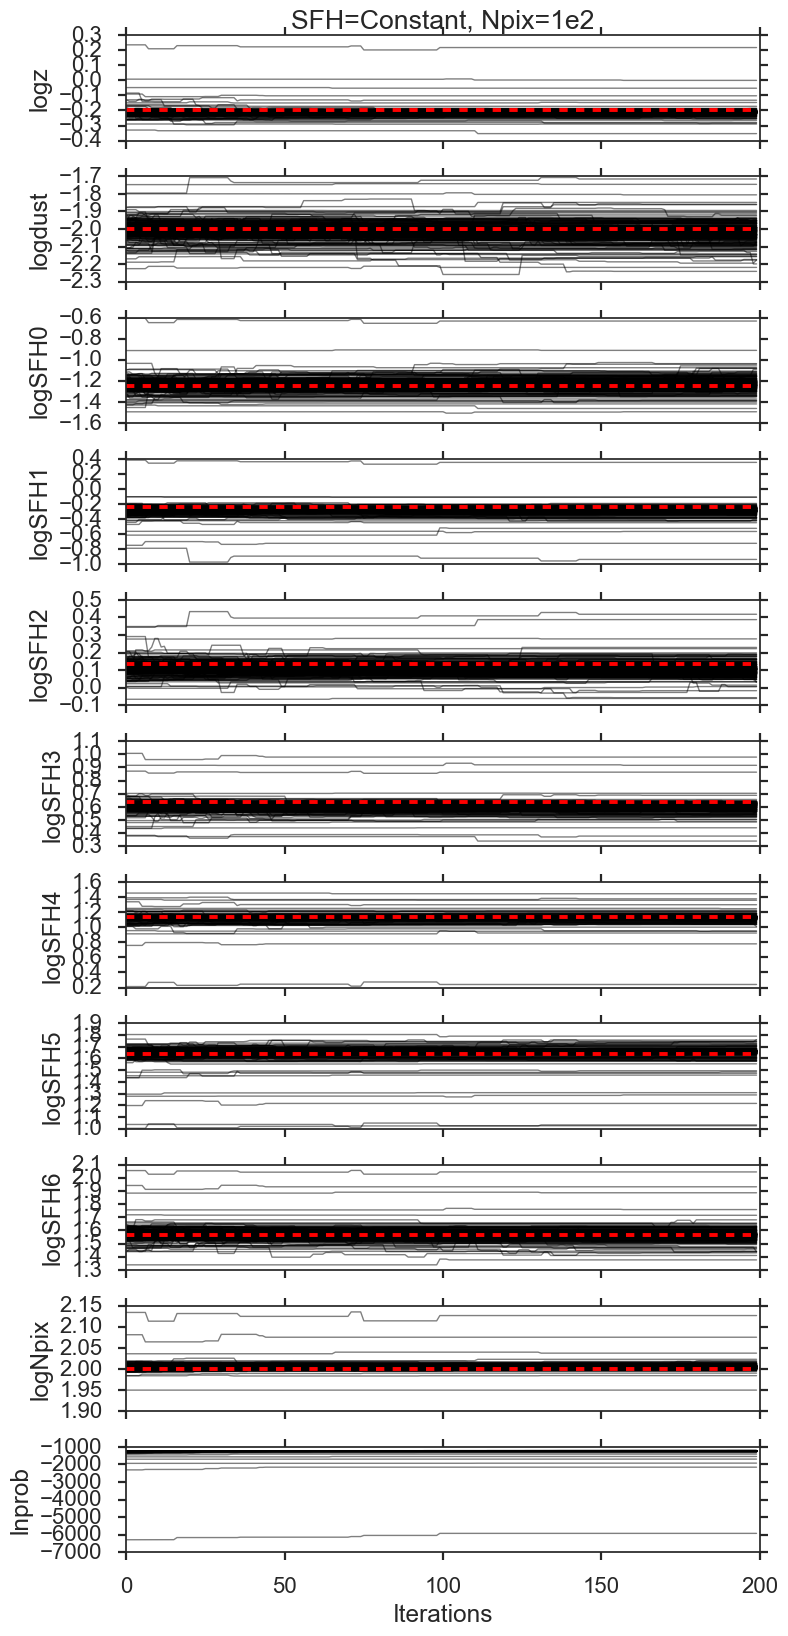

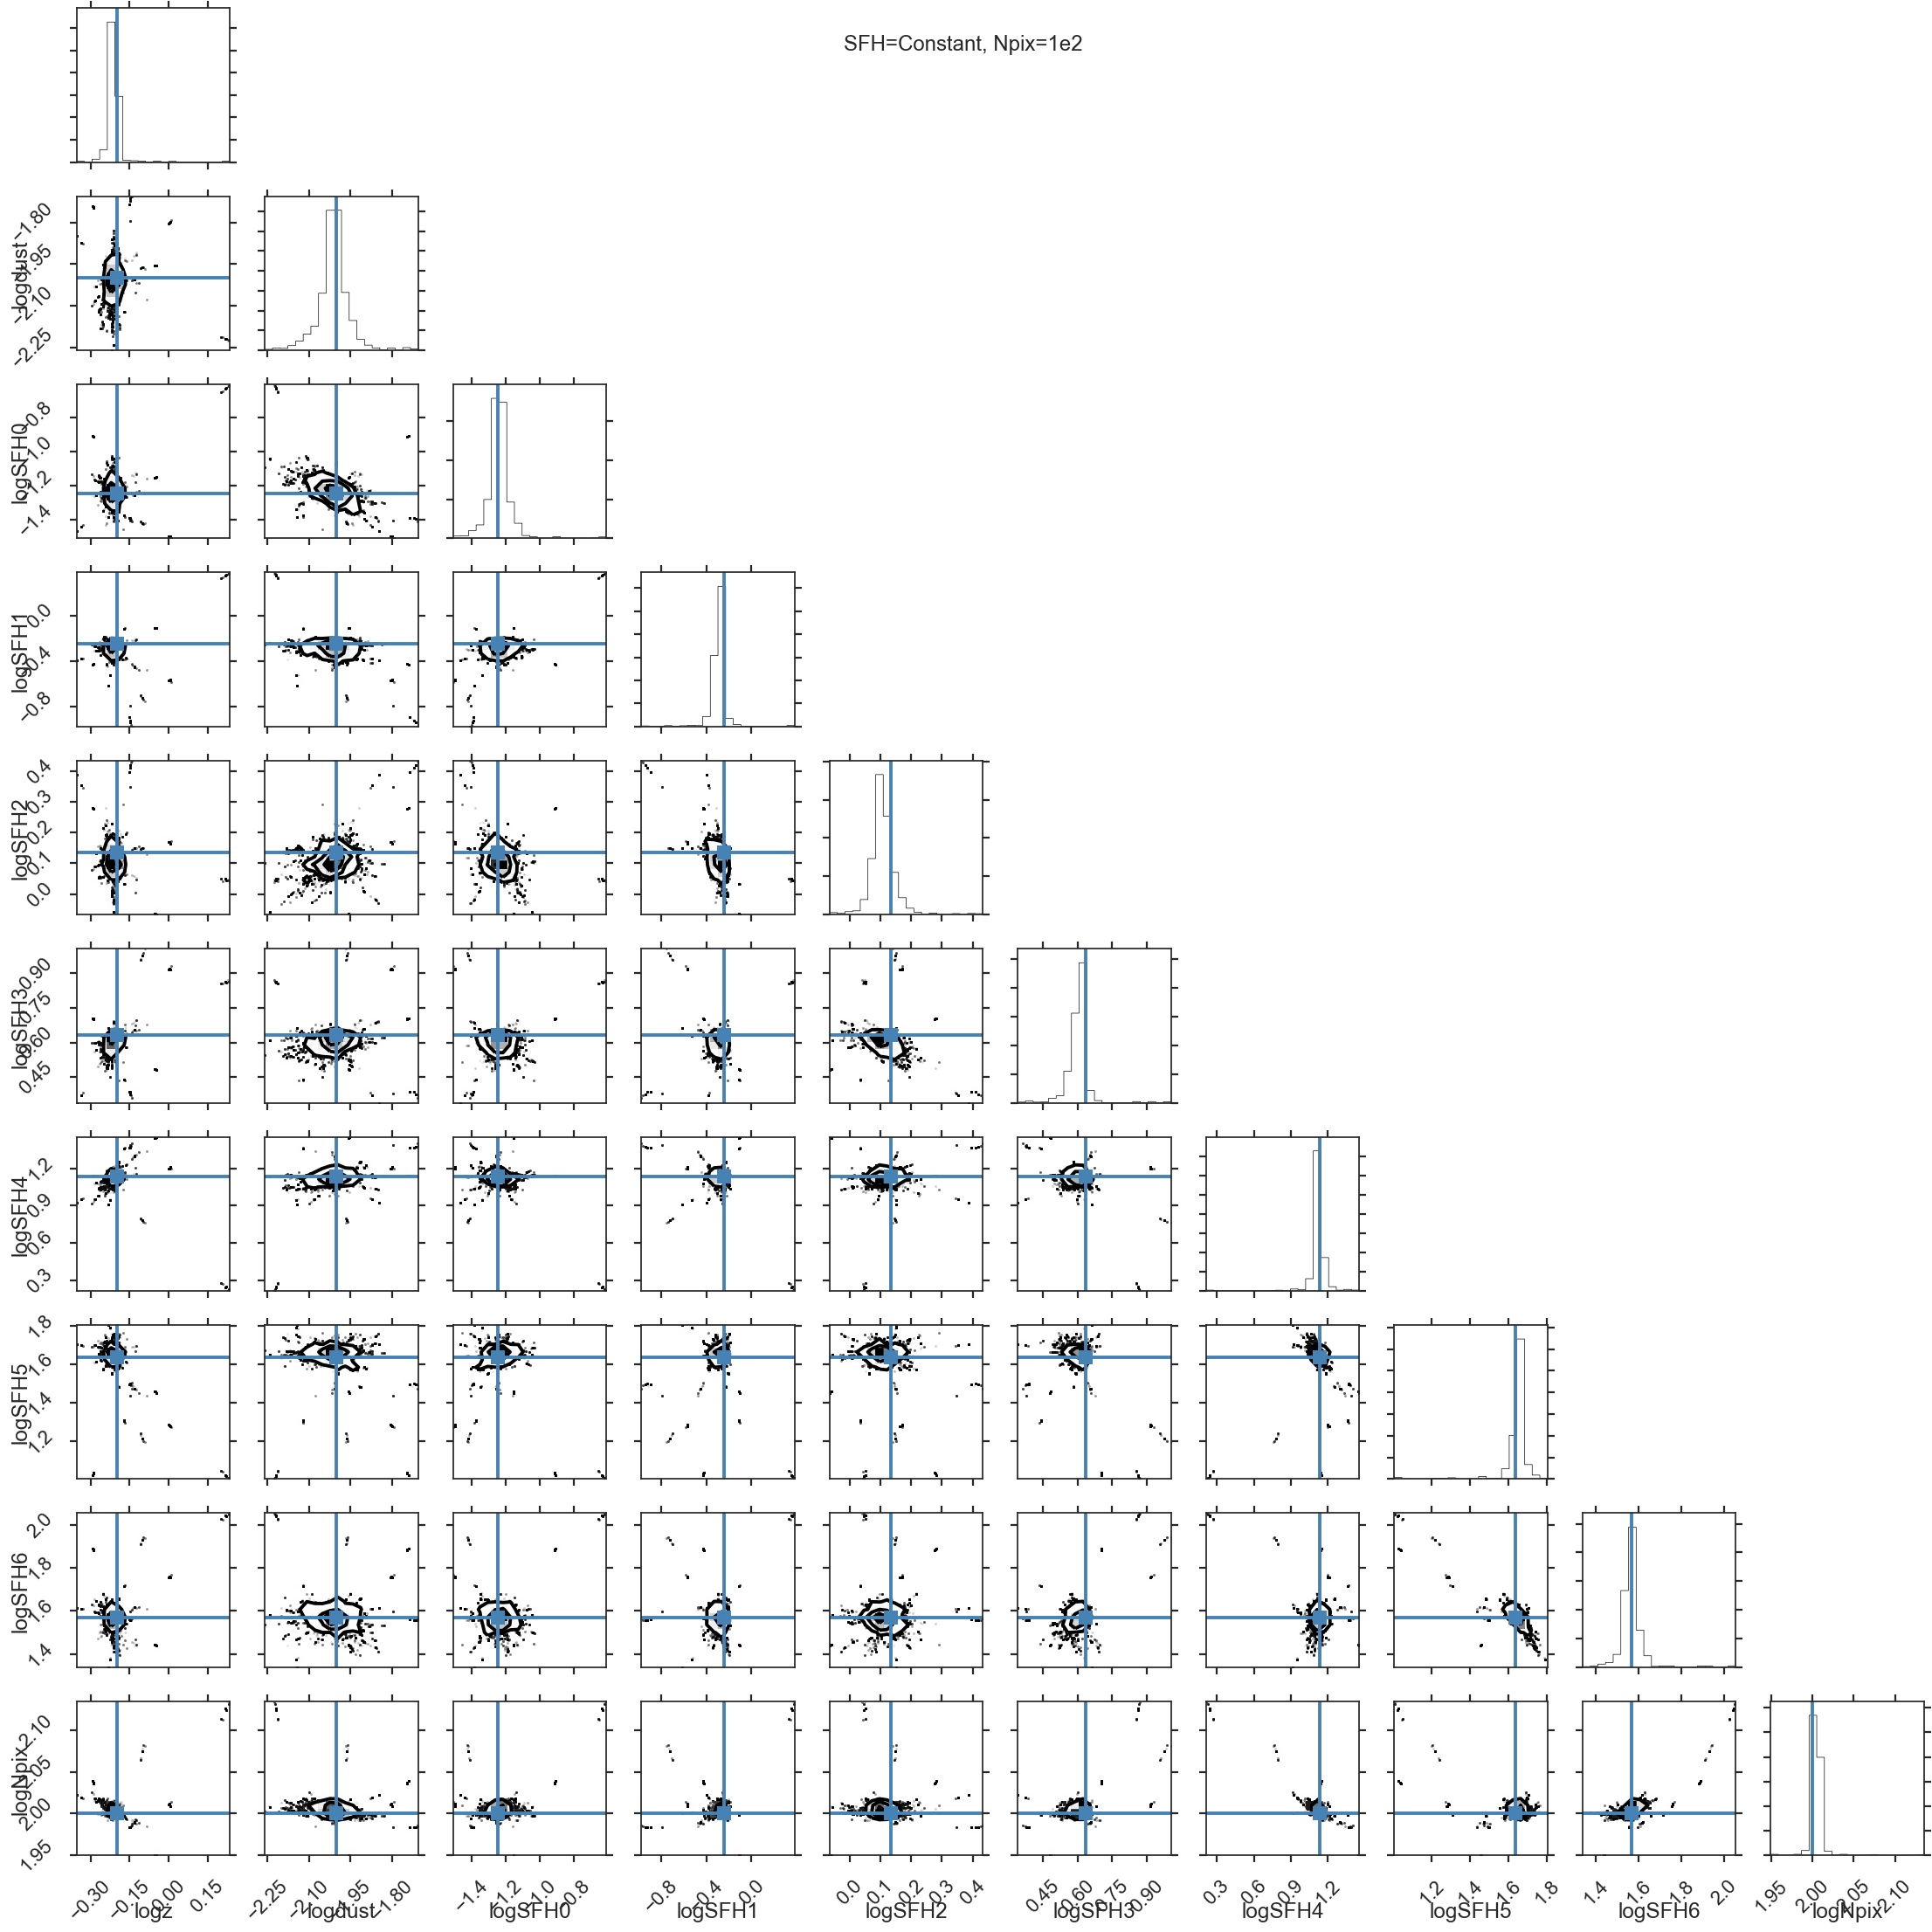

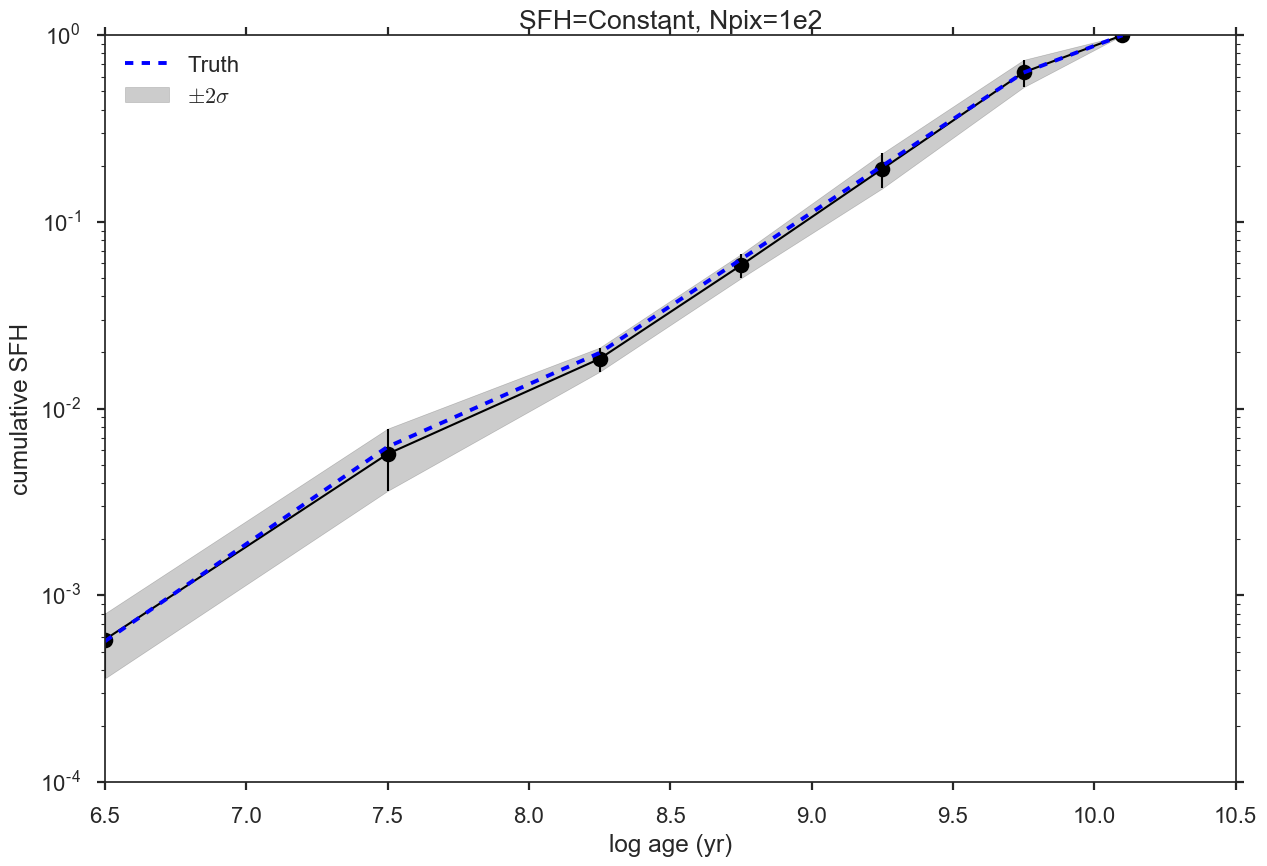

In [24]:
run_full = PCMD_run('results/FULL_mock.csv', truths=FULL_truths(), title='SFH=Constant, Npix=1e2')
run_full.chain_plot()
run_full.corner_plot()
run_full.cumSFH_plot()

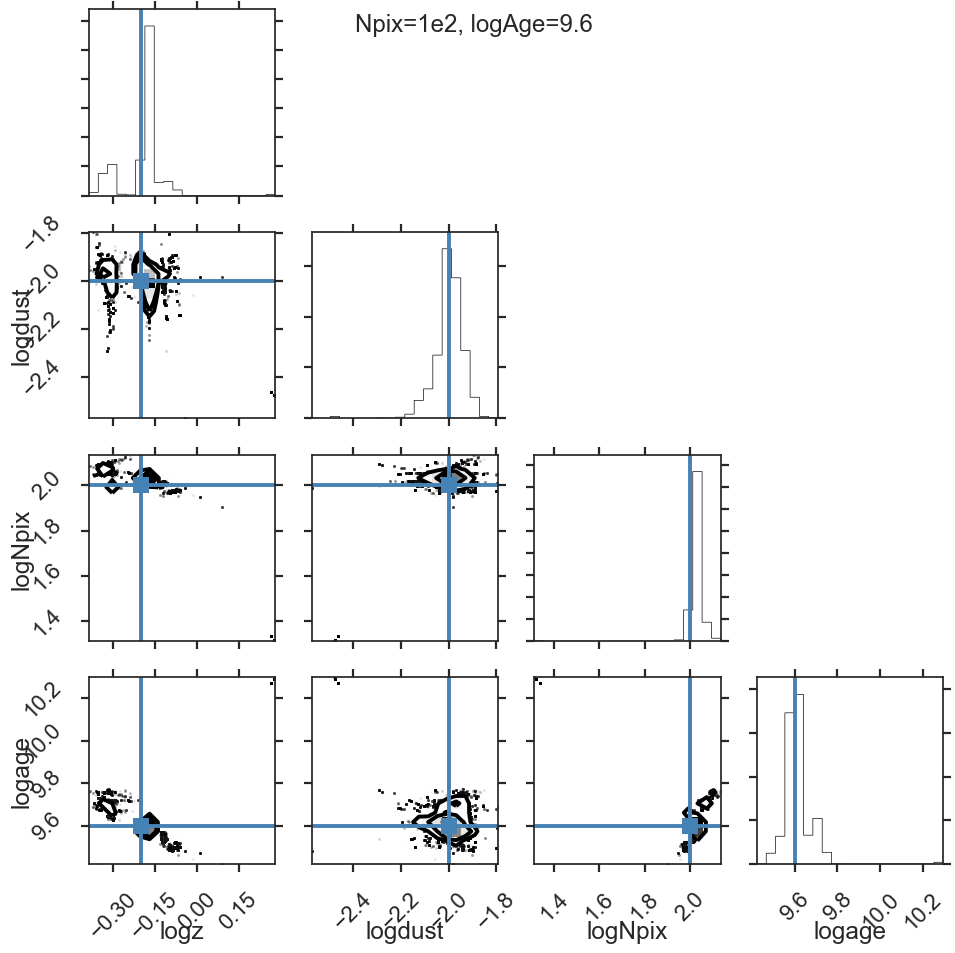

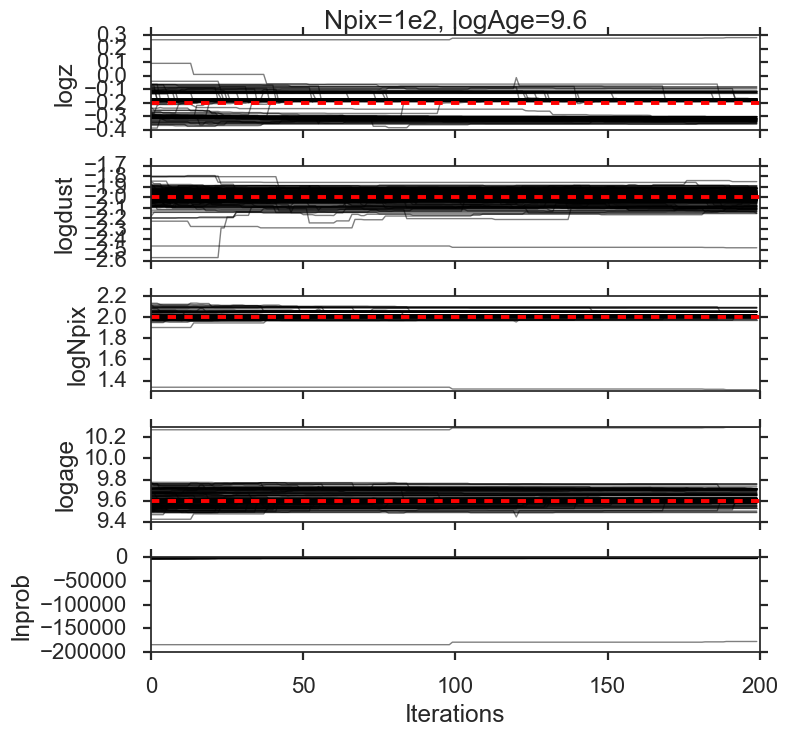

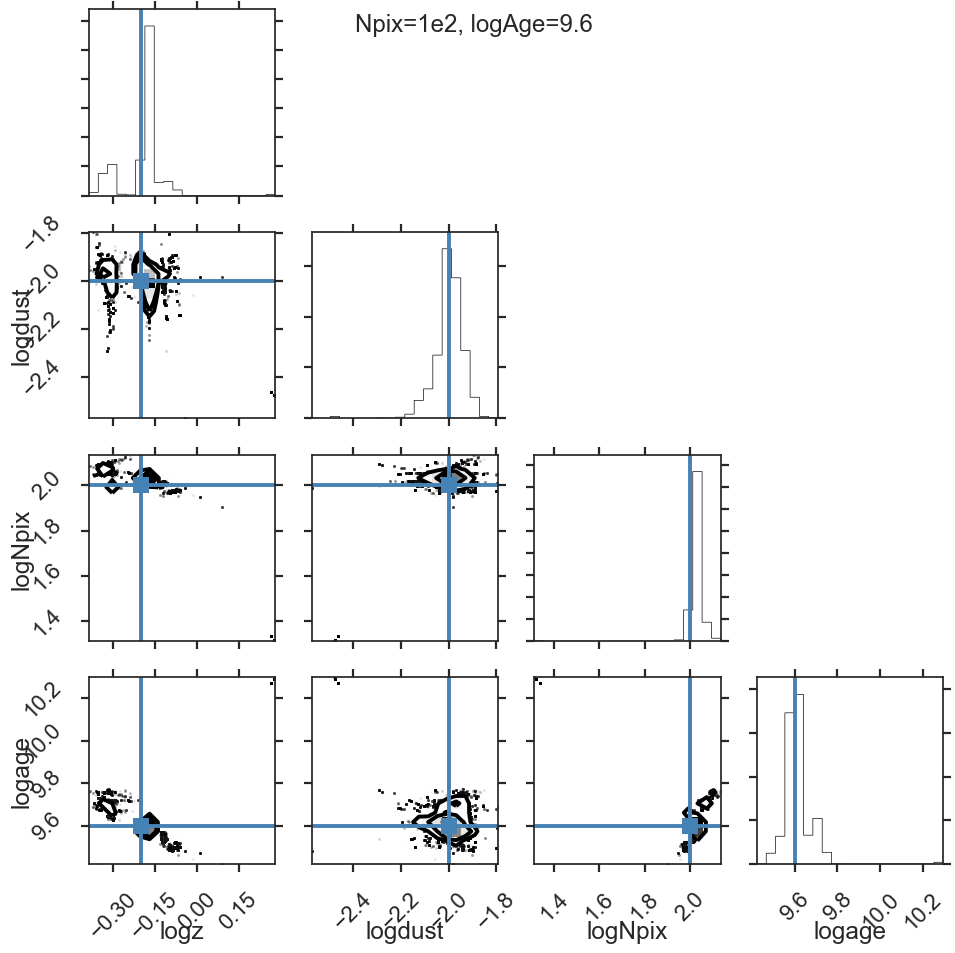

In [27]:
run_SSP = PCMD_run('results/SSP_mock.csv', truths=SSP_truths(), simple=True, title='Npix=1e2, logAge=9.6')
run_SSP.chain_plot()
run_SSP.corner_plot()

(array([  5.97945702e-04,   6.86888536e-03,   2.00636740e-02,
         6.47134133e-02,   1.99519183e-01,   6.24611509e-01,
         1.00000000e+00]), array([  9.44503603e-05,   1.22038919e-02,   1.38826598e-02,
         1.80882001e-02,   4.07356949e-02,   4.78359732e-02,
         5.23372484e-16]))


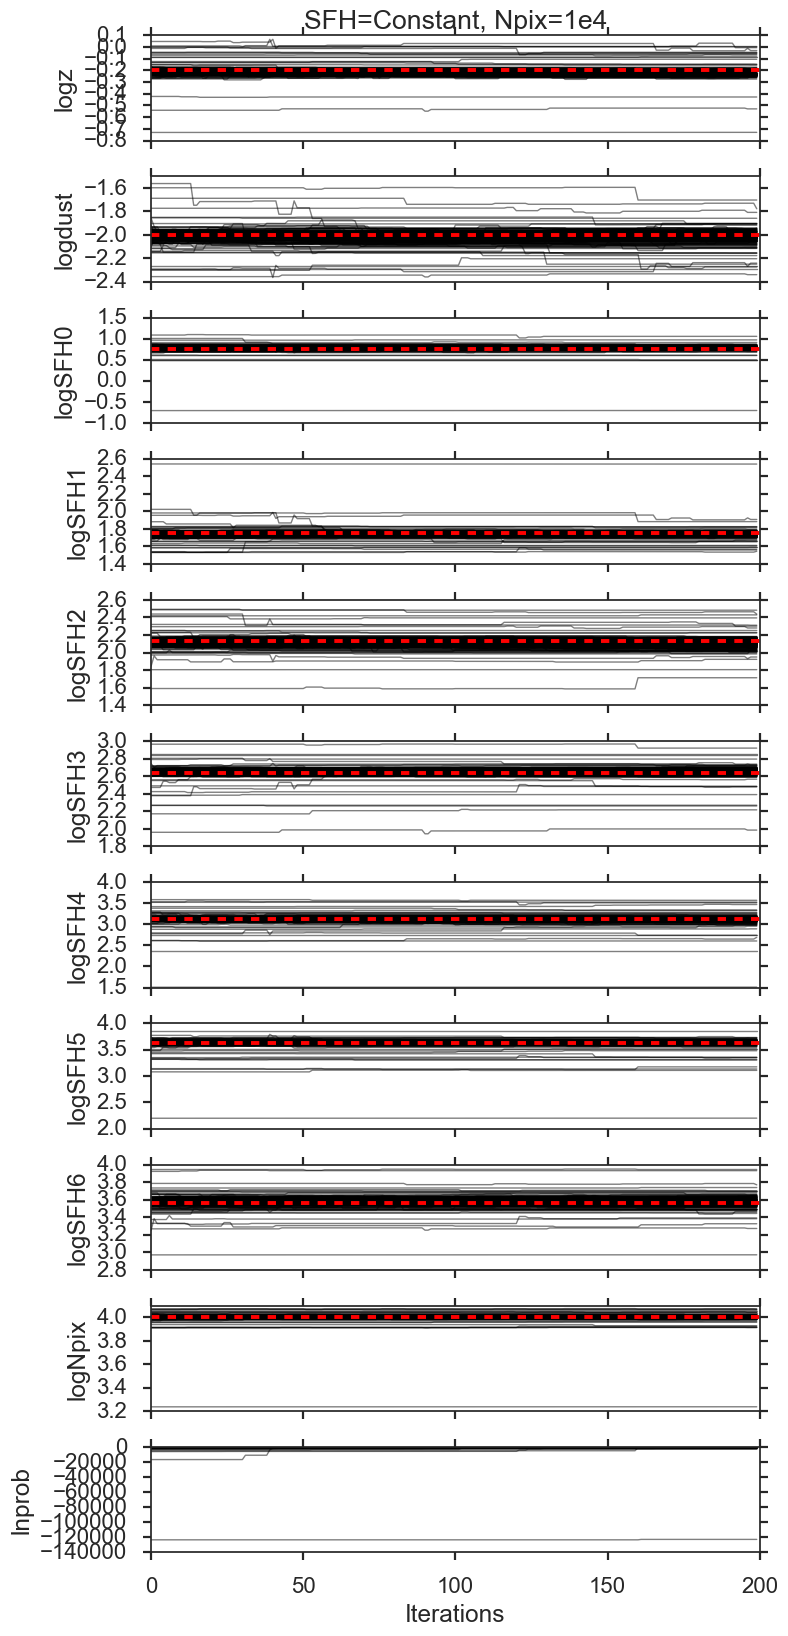

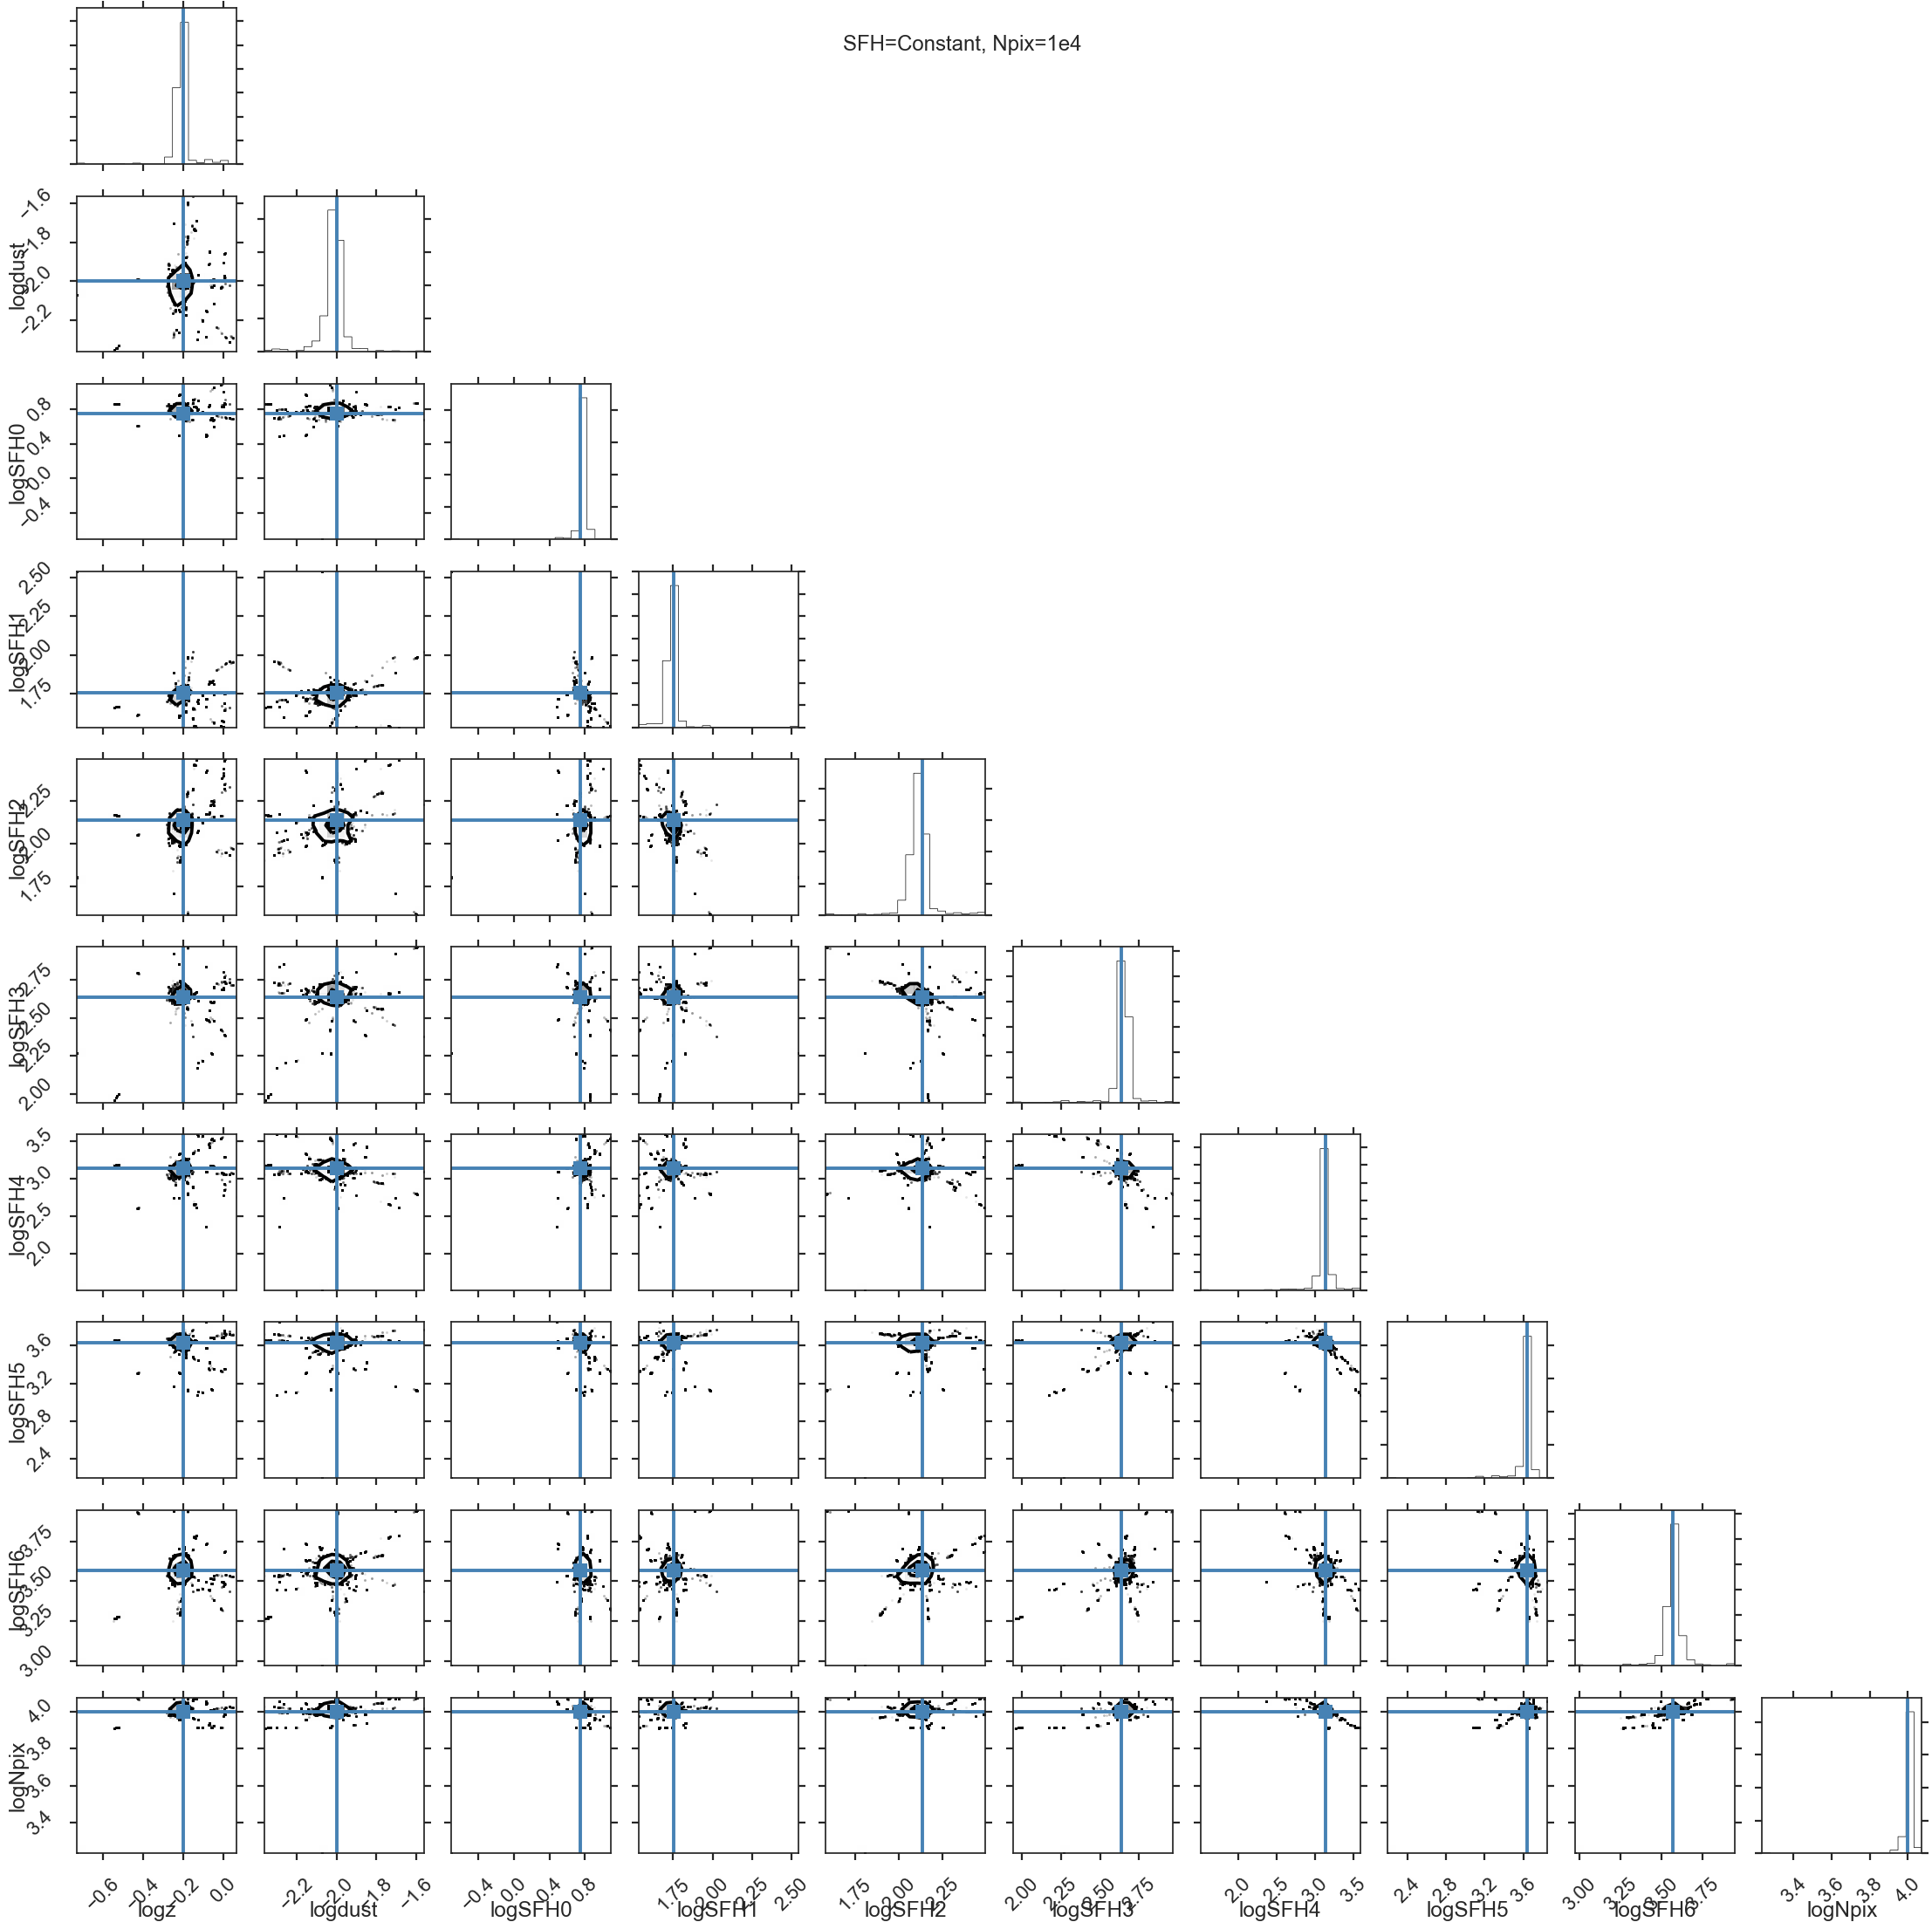

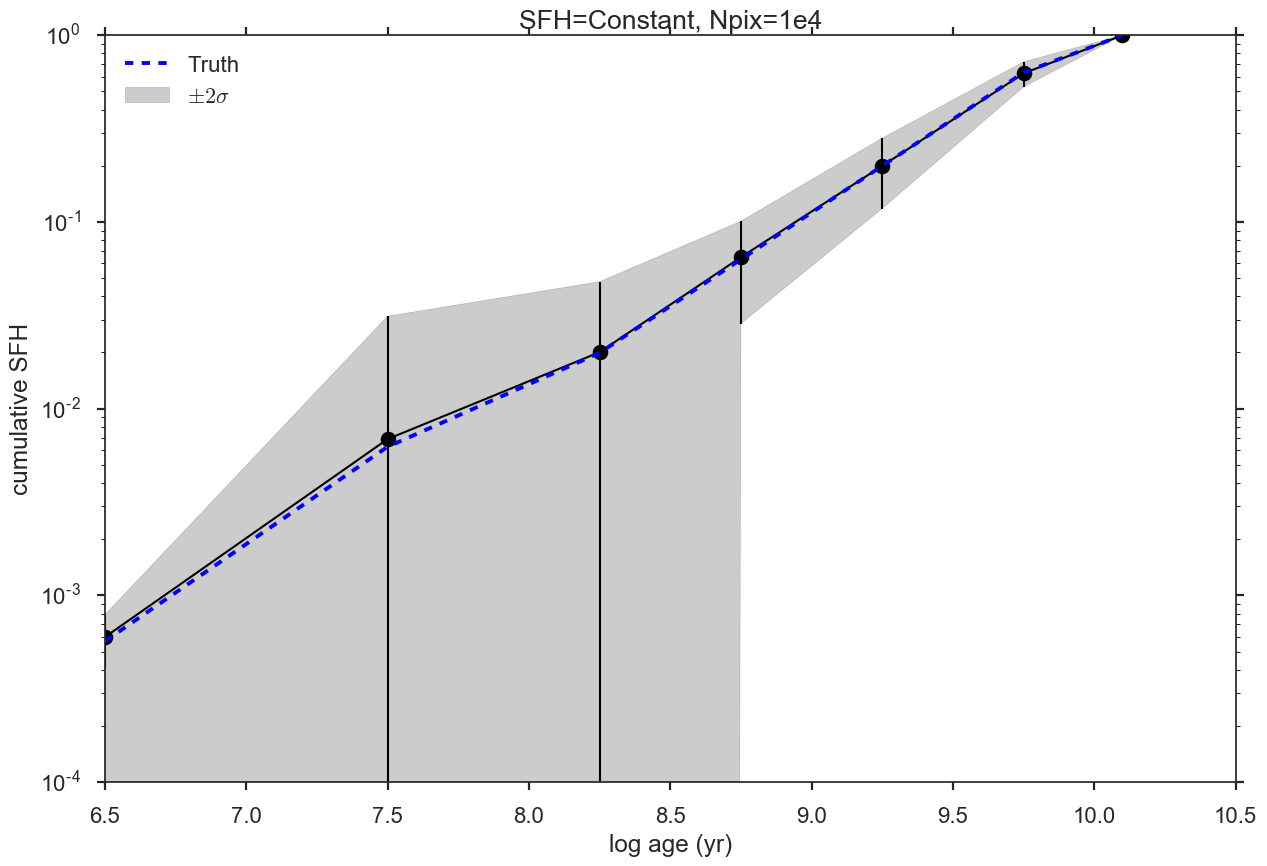

In [28]:
run_1e4 = PCMD_run('results/FULL_1e4_mock.csv', truths=FULL_truths(Npix=1e4), title='SFH=Constant, Npix=1e4')
run_1e4.chain_plot()
run_1e4.corner_plot()
run_1e4.cumSFH_plot()

(array([  6.43579996e-04,   1.60292920e-02,   4.11710572e-02,
         1.00922763e-01,   2.53704561e-01,   6.66285799e-01,
         1.00000000e+00]), array([  5.38146618e-04,   6.78188267e-03,   9.50995208e-03,
         1.66332520e-02,   6.45882643e-02,   9.22112738e-02,
         2.06611319e-16]))


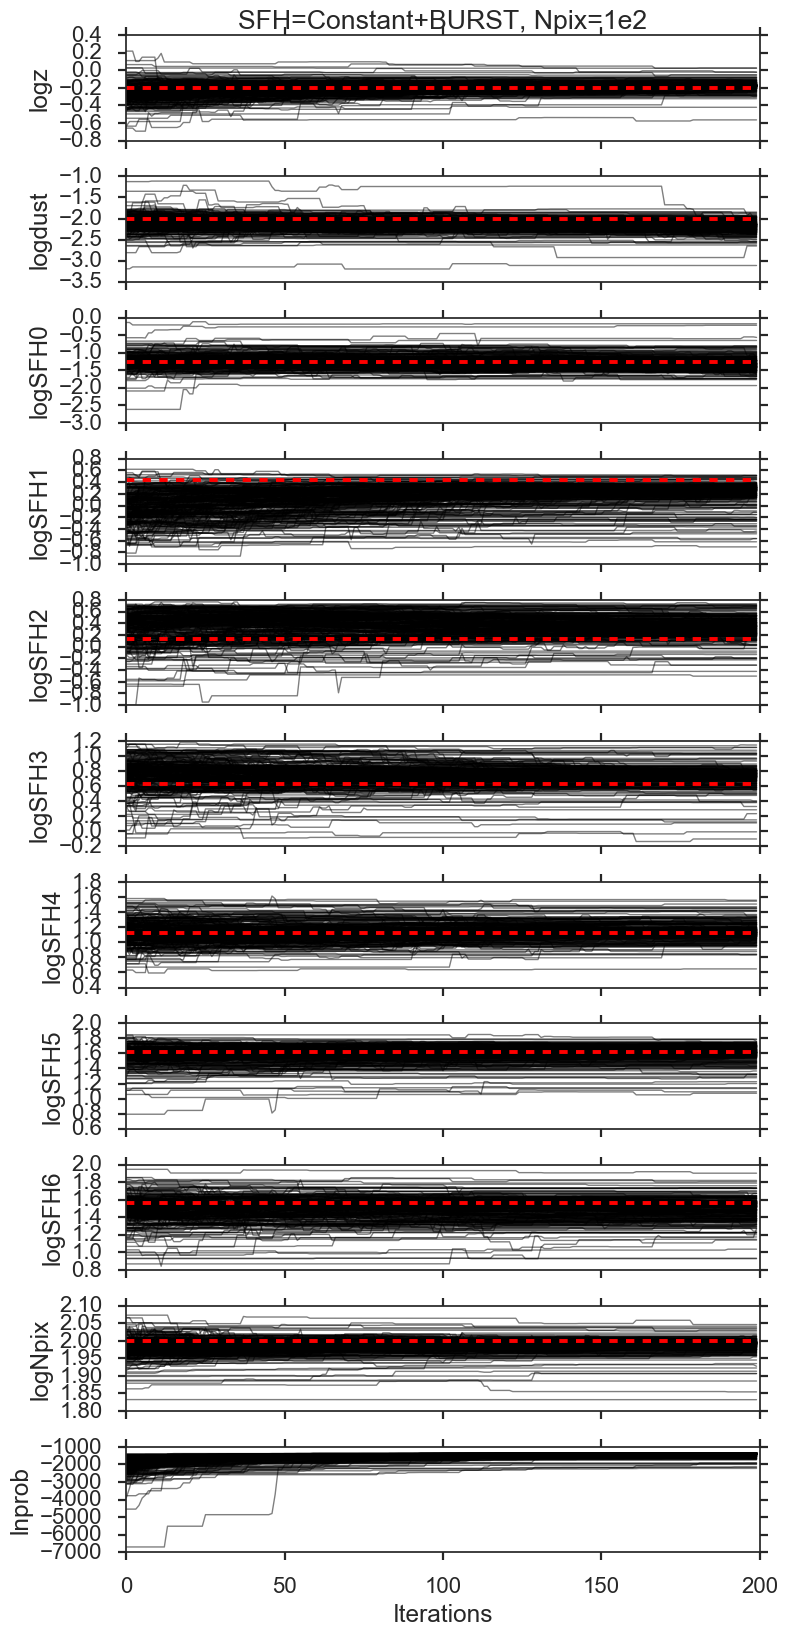

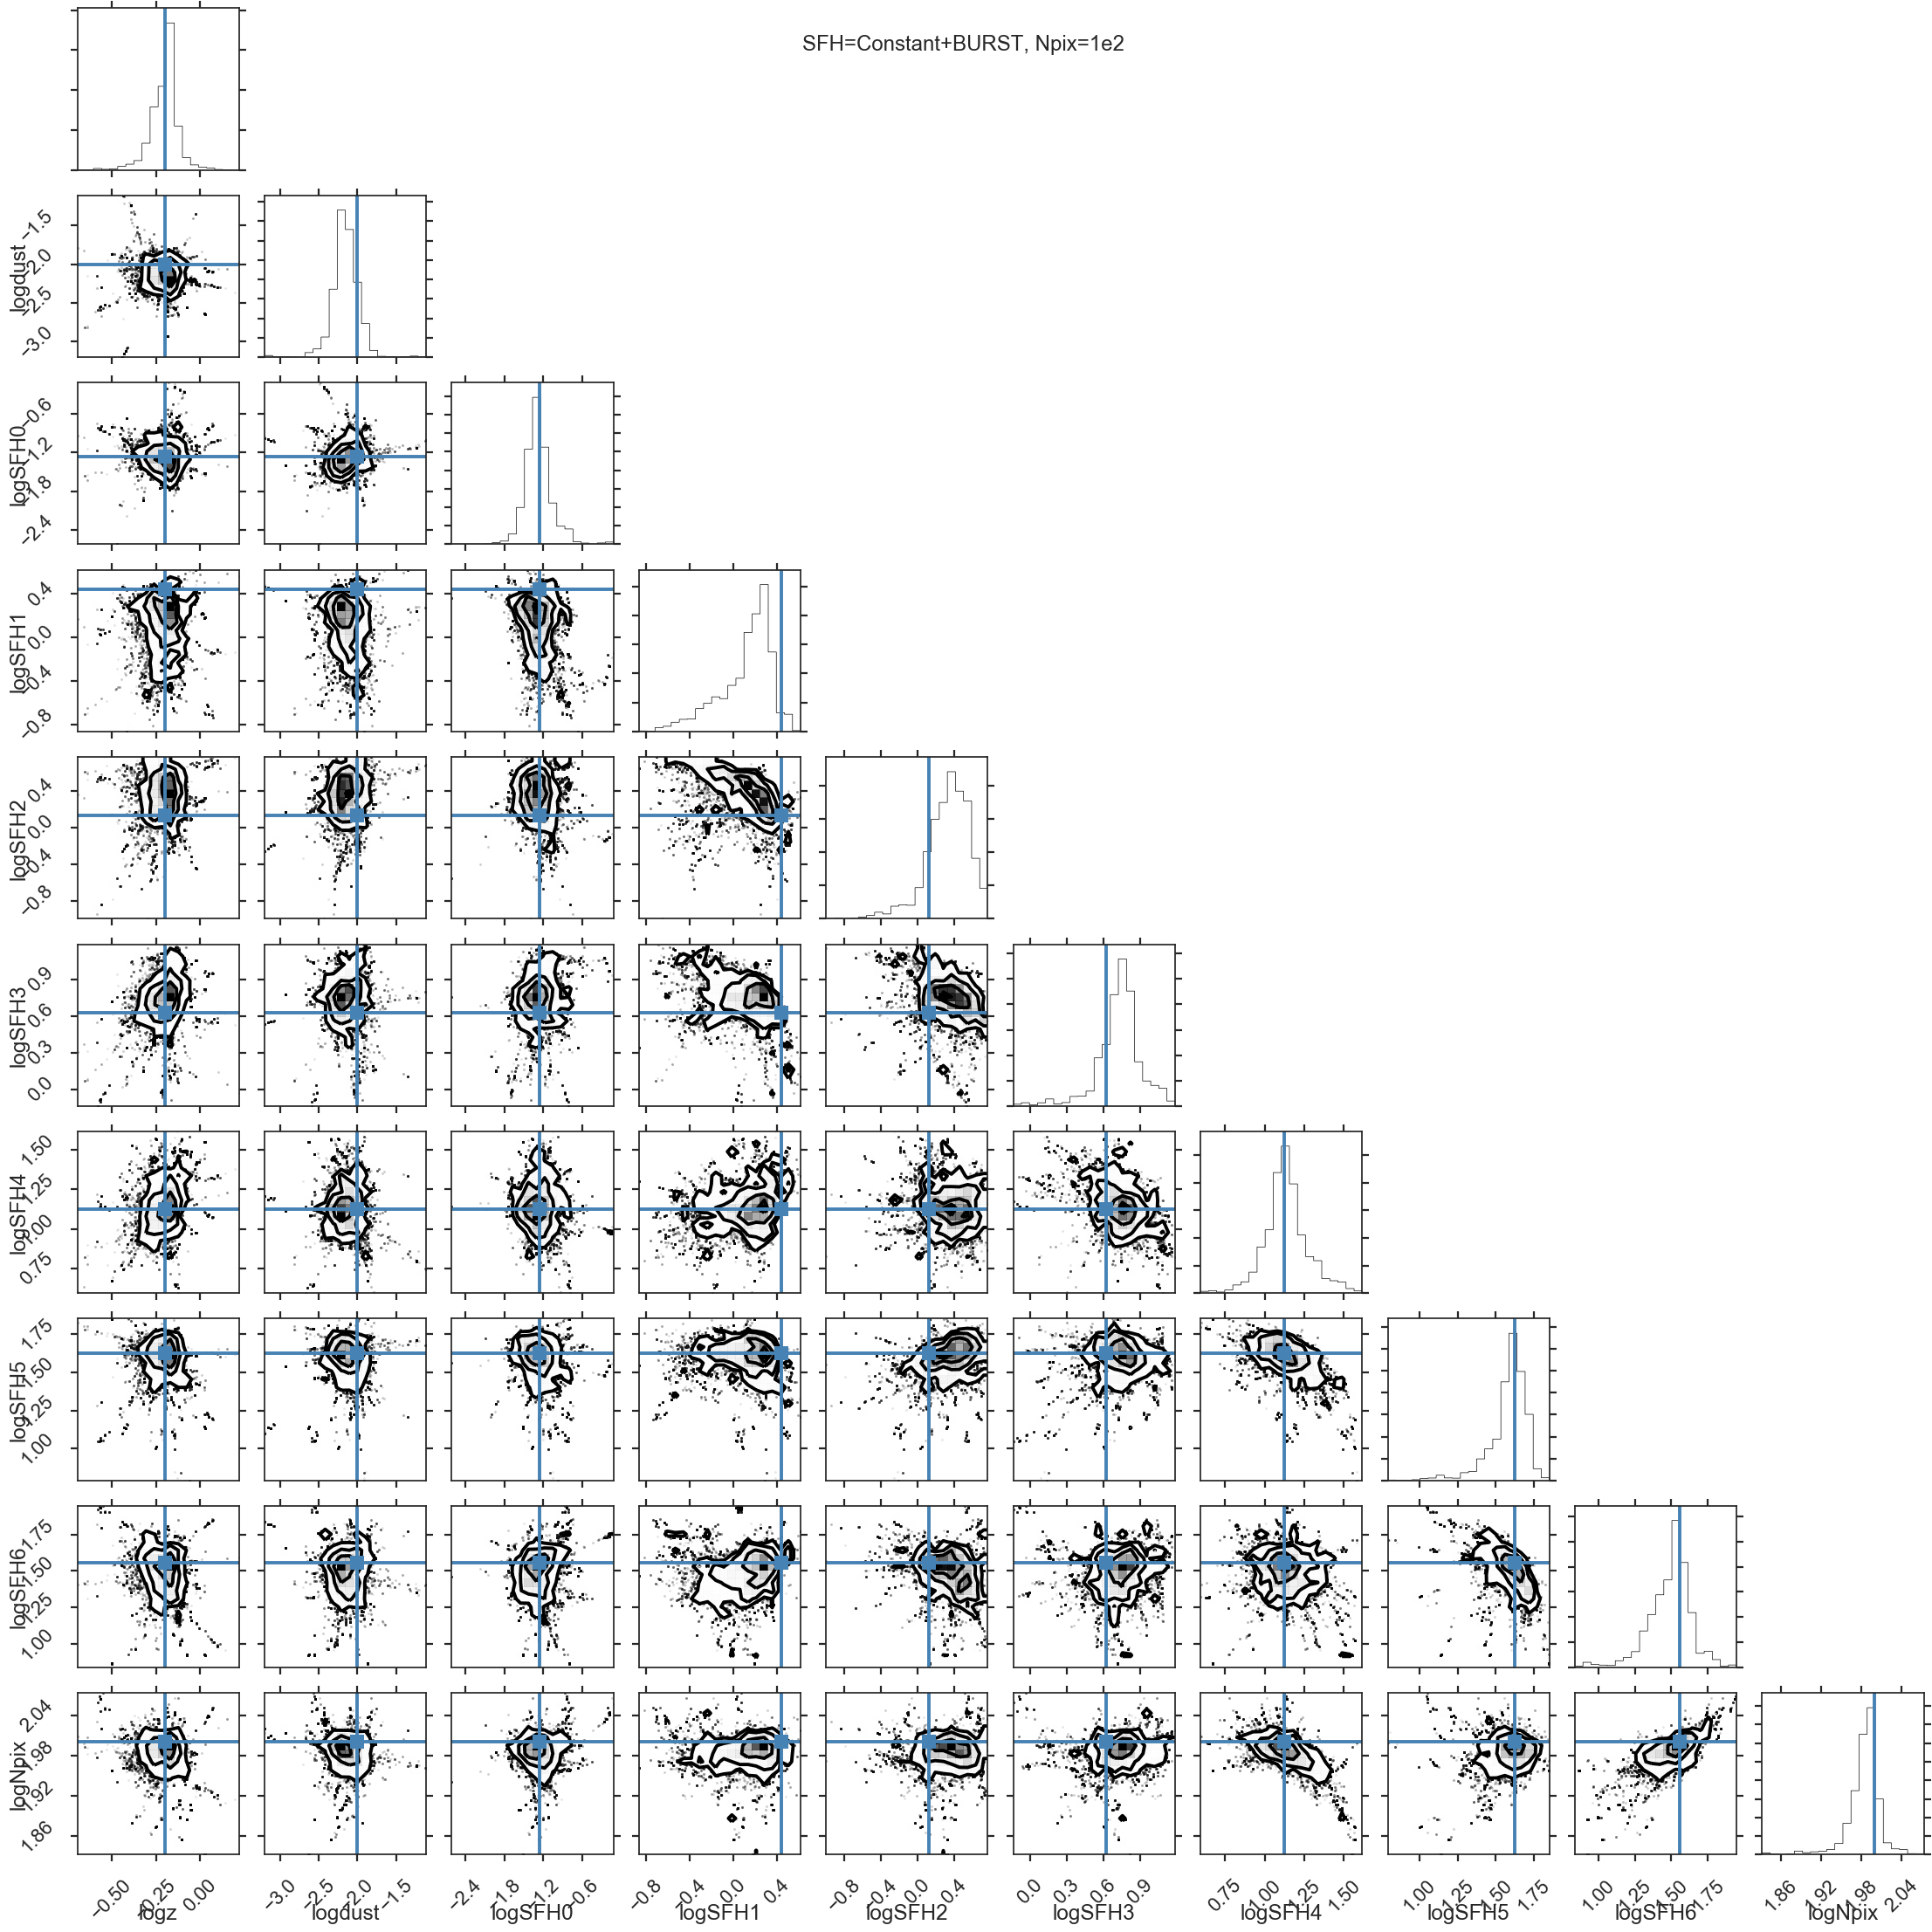

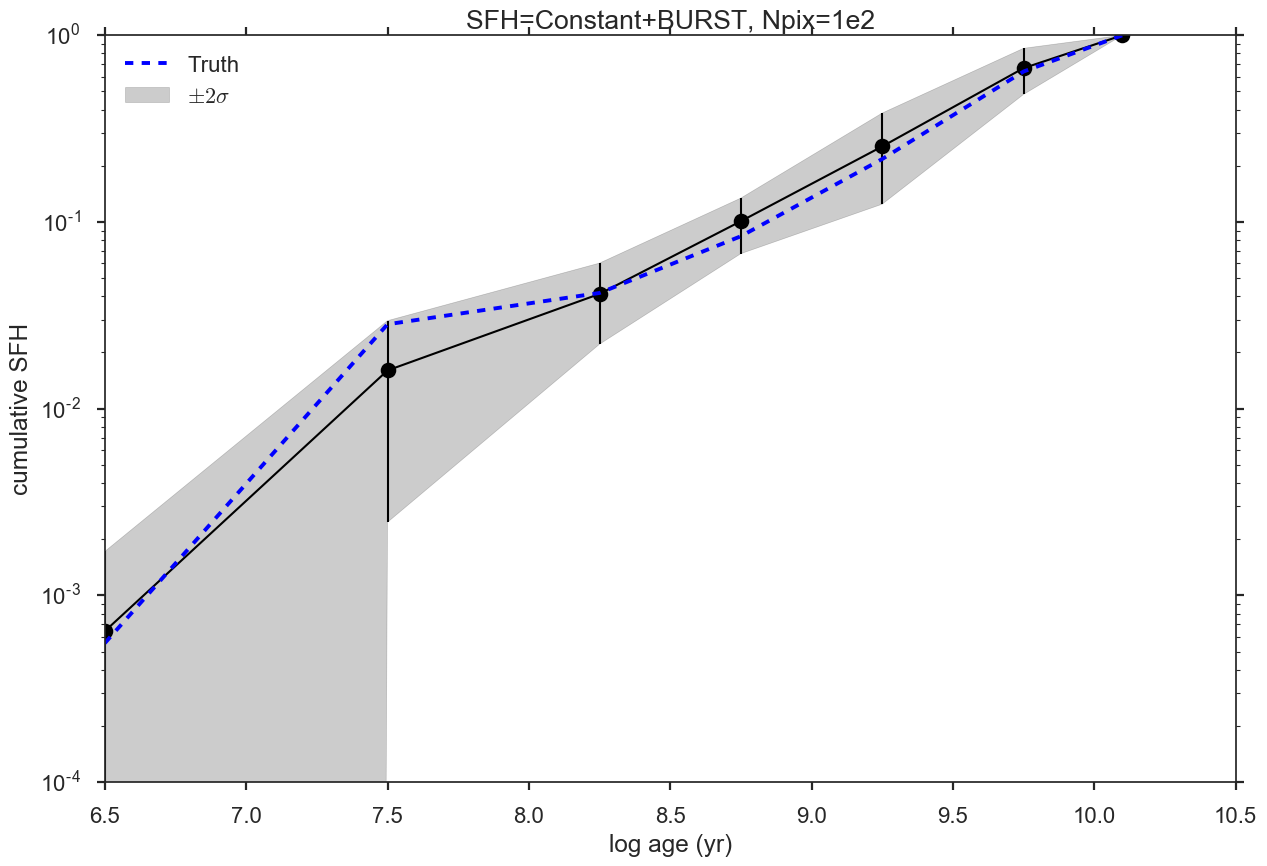

In [30]:
run_burst = PCMD_run('results/BURST_mock.csv', truths=BURST_truths(), title='SFH=Constant+BURST, Npix=1e2')
run_burst.chain_plot()
run_burst.corner_plot()
run_burst.cumSFH_plot()

(array([ 0.00852131,  0.08575586,  0.2273365 ,  0.63034348,  0.9614151 ,
        0.99995536,  1.        ]), array([  1.12753639e-03,   4.80664077e-03,   1.35950260e-02,
         2.96825330e-02,   8.96380676e-03,   9.37890279e-06,
         3.02796666e-16]))


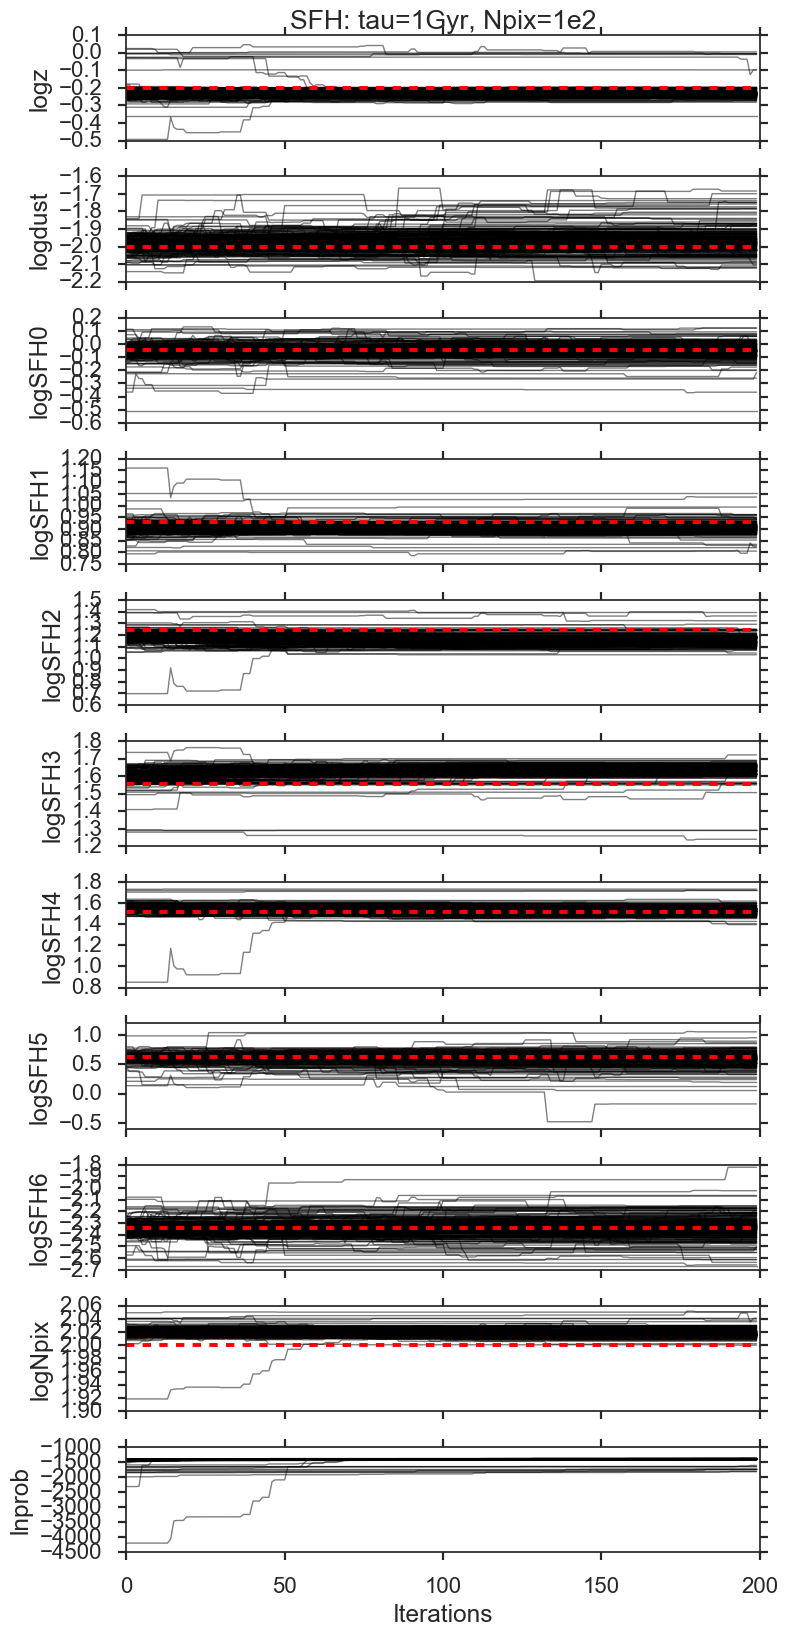

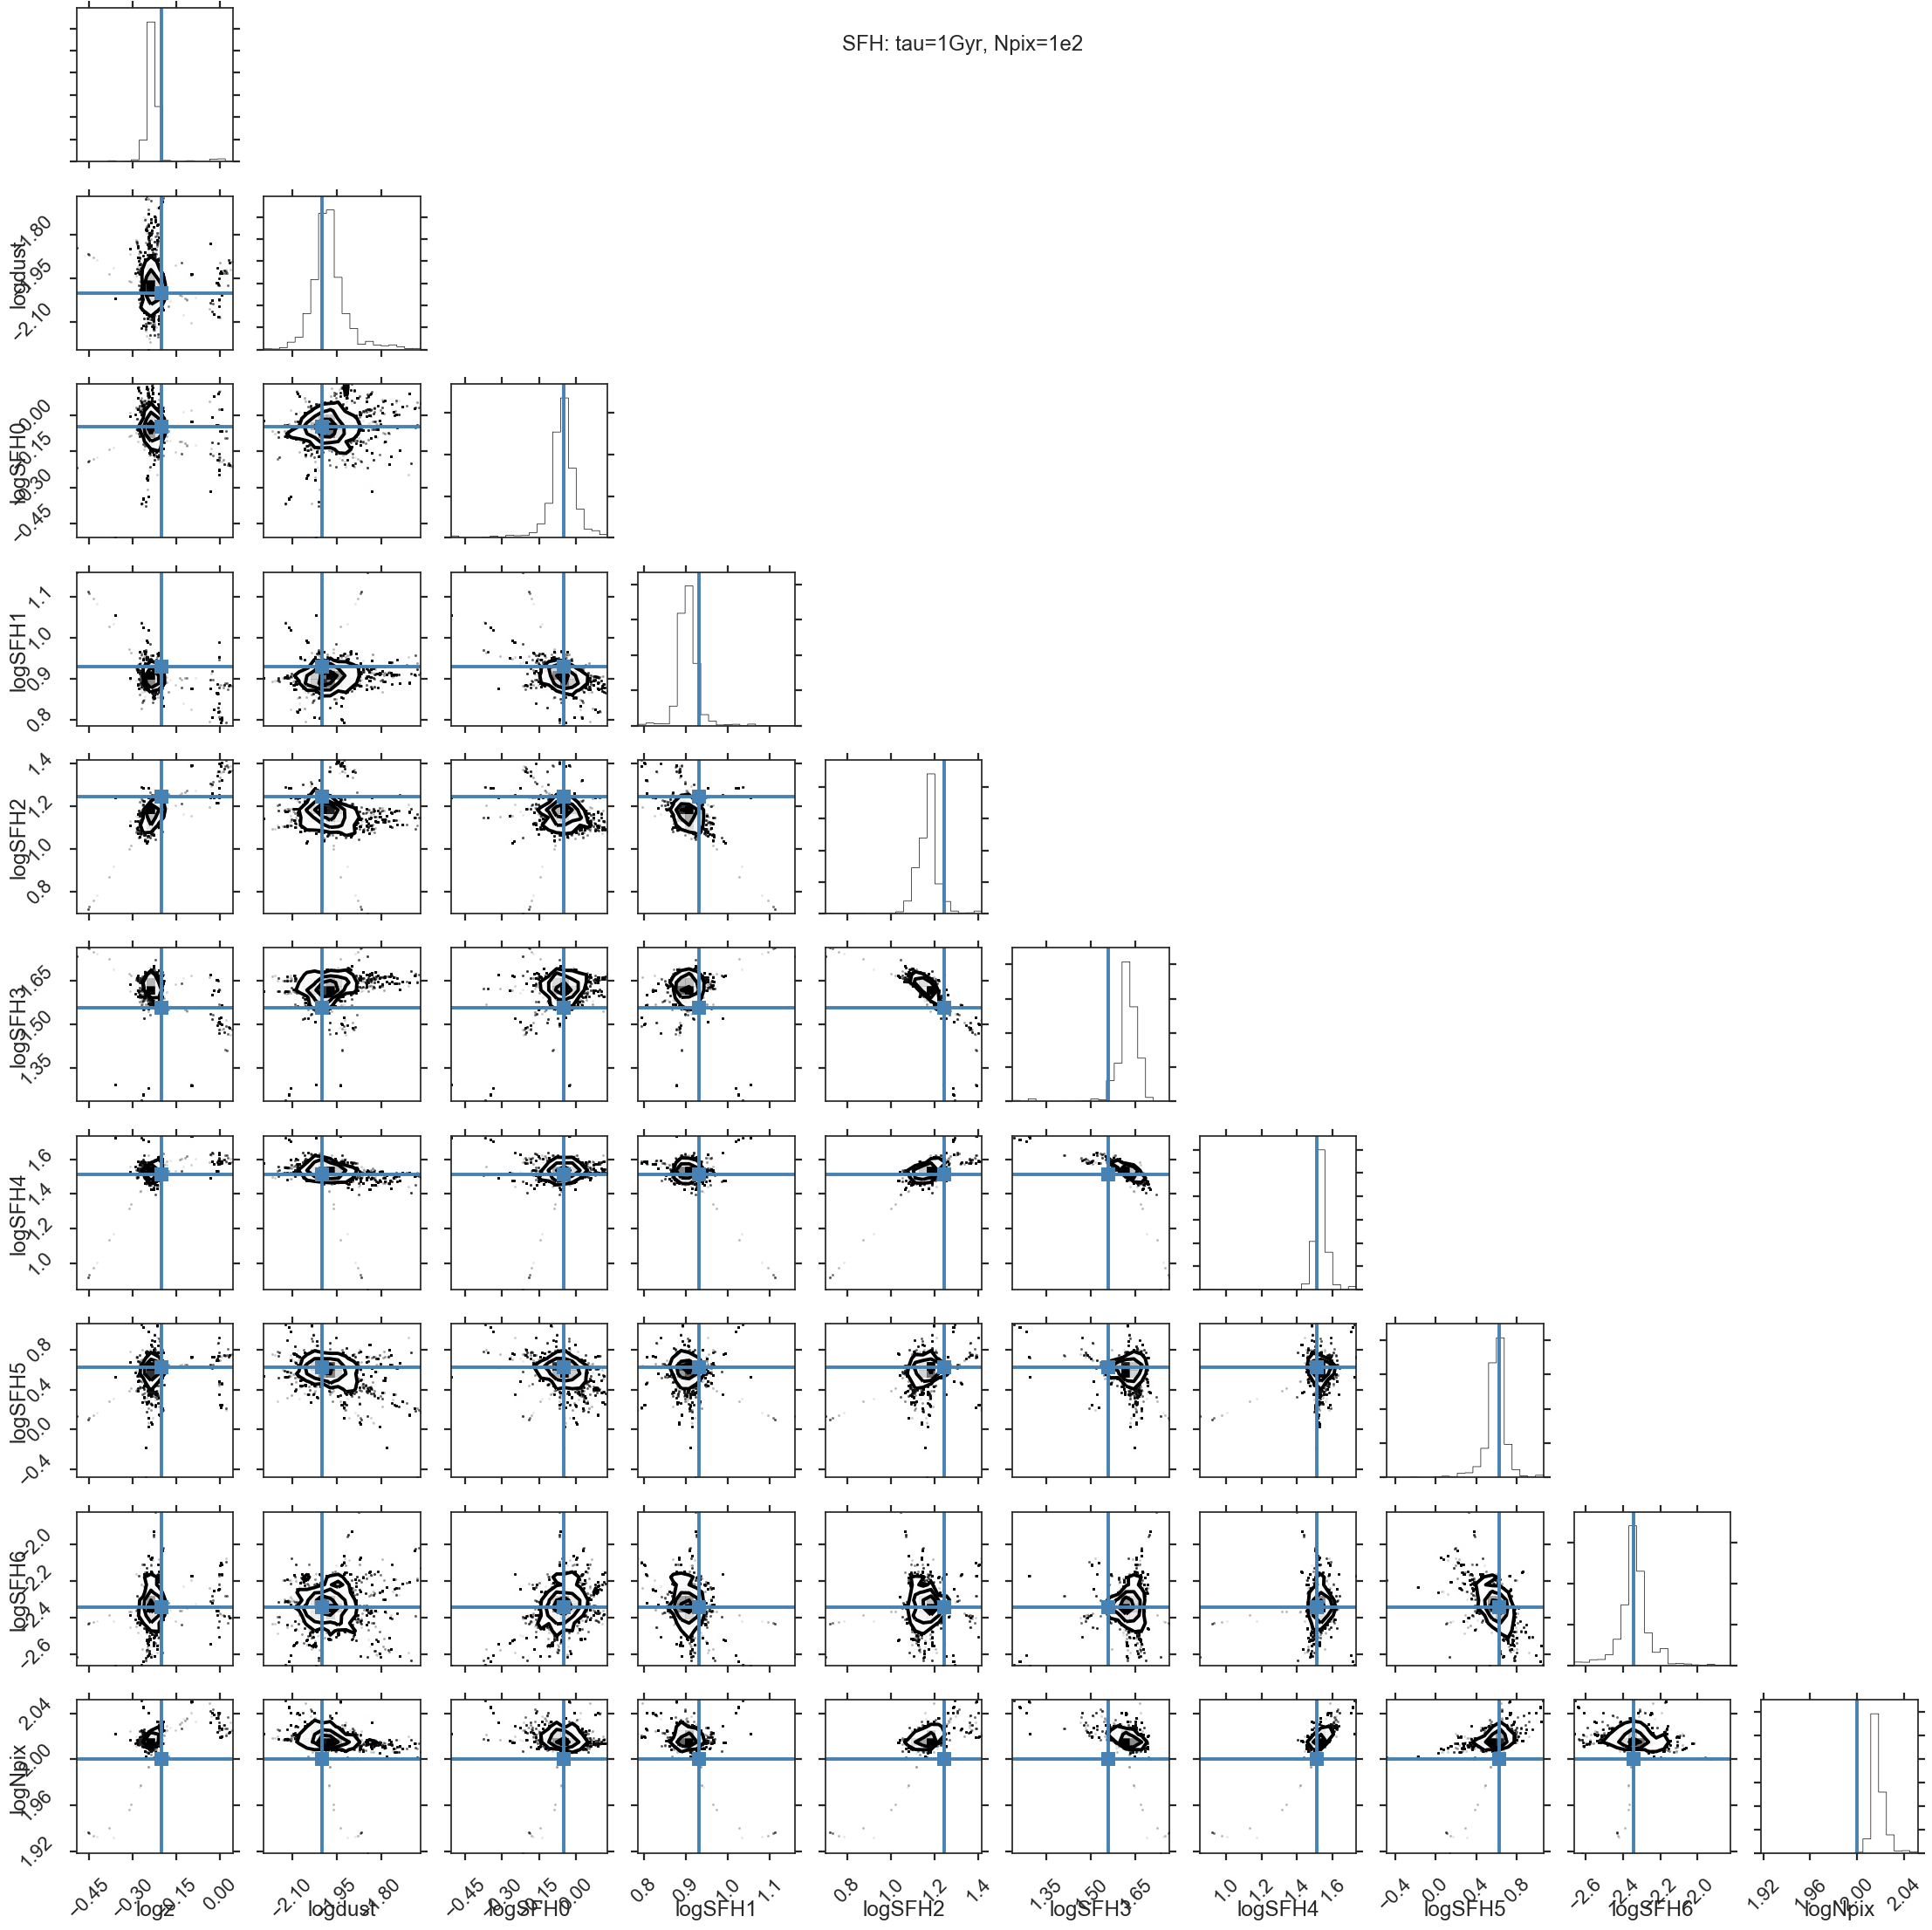

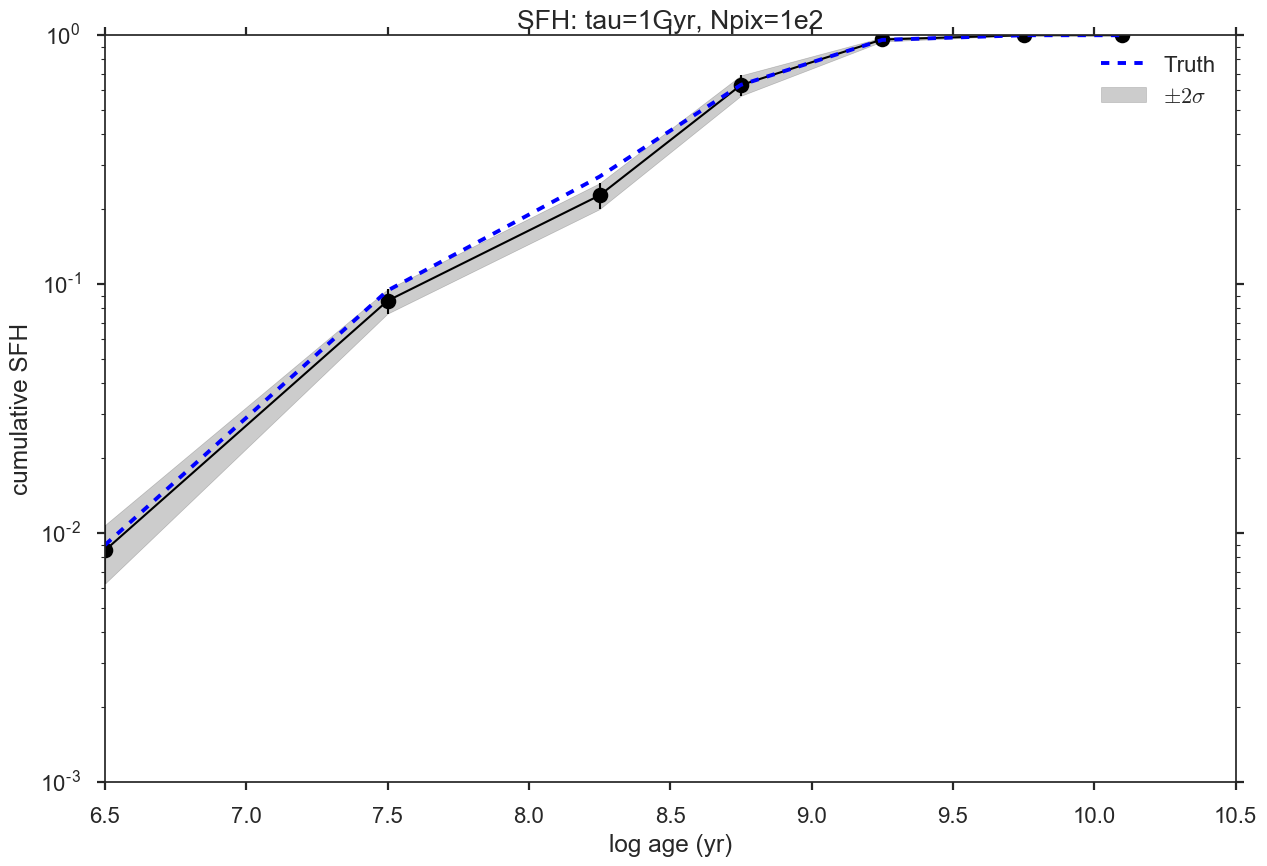

In [31]:
run_tau = PCMD_run('results/TAU_mock.csv', truths=TAU_truths(), title='SFH: tau=1Gyr, Npix=1e2')
run_tau.chain_plot()
run_tau.corner_plot()
run_tau.cumSFH_plot()

(array([  1.21011045e-04,   1.22607448e-03,   2.88700938e-03,
         6.62055689e-03,   1.43114147e-01,   7.50885092e-01,
         1.00000000e+00]), array([  2.06076412e-04,   9.02565196e-04,   2.73896389e-03,
         7.64048286e-03,   8.30817988e-02,   1.51118497e-01,
         3.07714324e-16]))


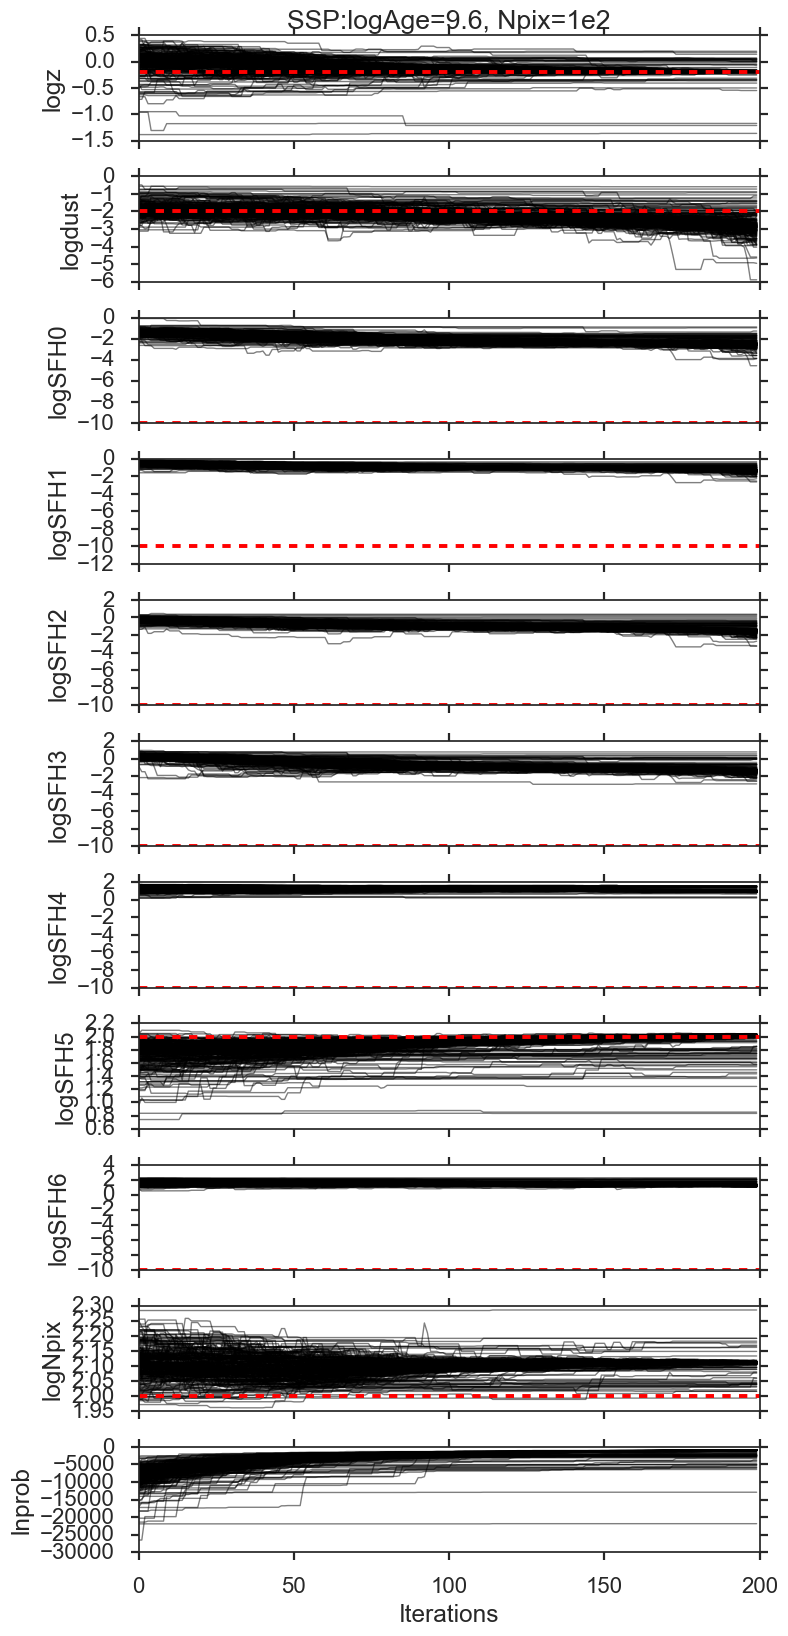

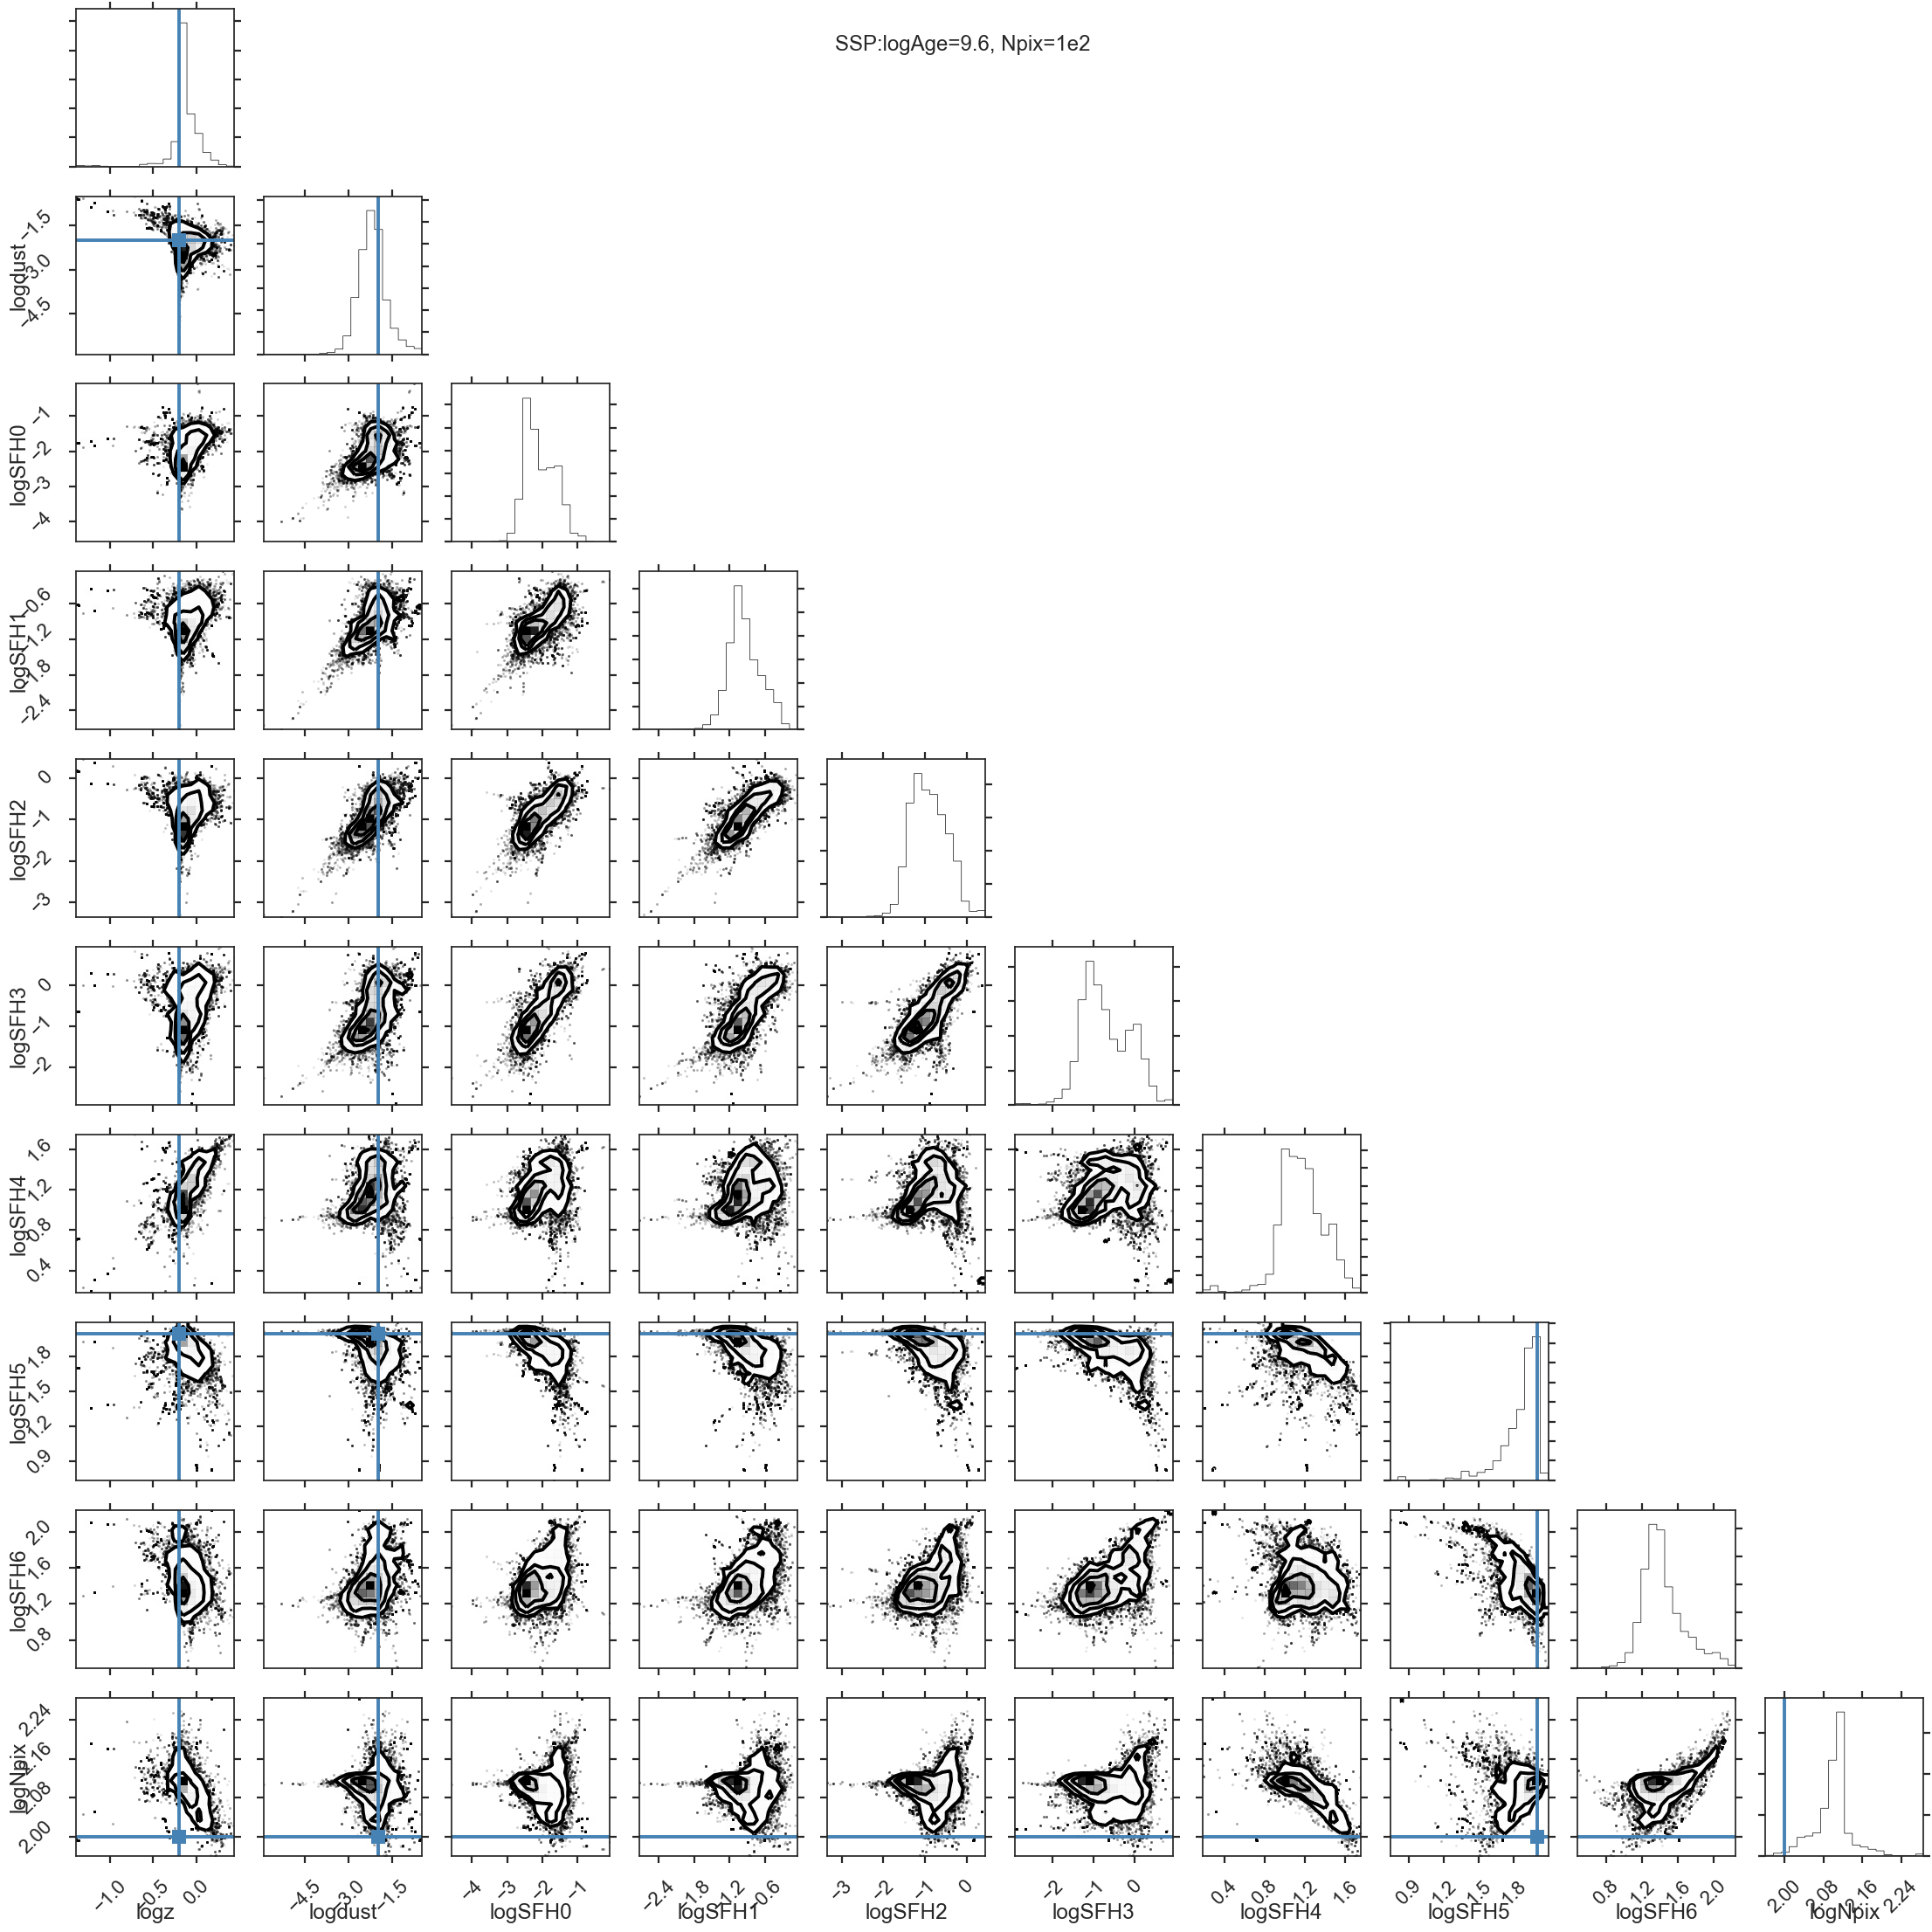

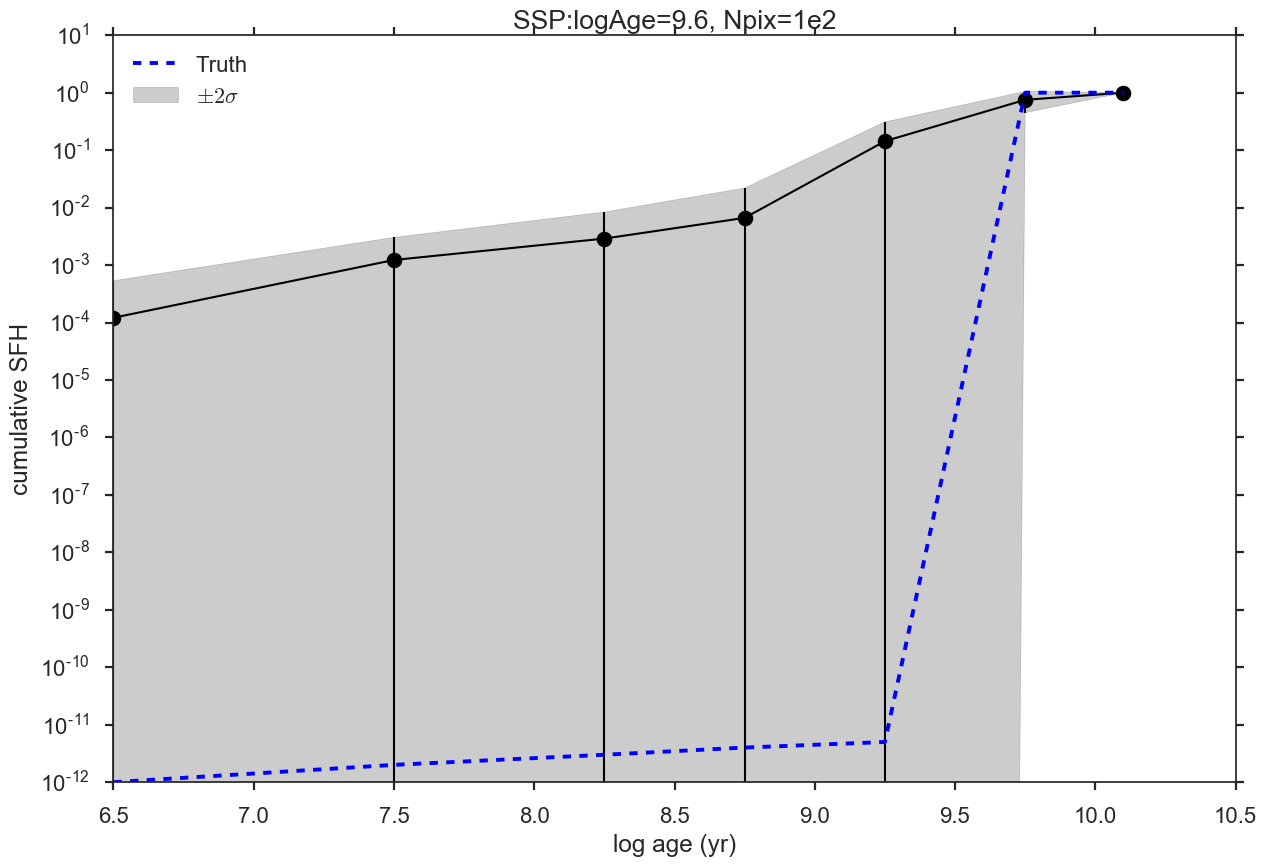

In [34]:
run_SSP_as_FULL = PCMD_run('results/SSP_as_FULL_mock.csv', truths=SSP_as_FULL_truths(), title='SSP:logAge=9.6, Npix=1e2')
run_SSP_as_FULL.chain_plot()
run_SSP_as_FULL.corner_plot()
run_SSP_as_FULL.cumSFH_plot()

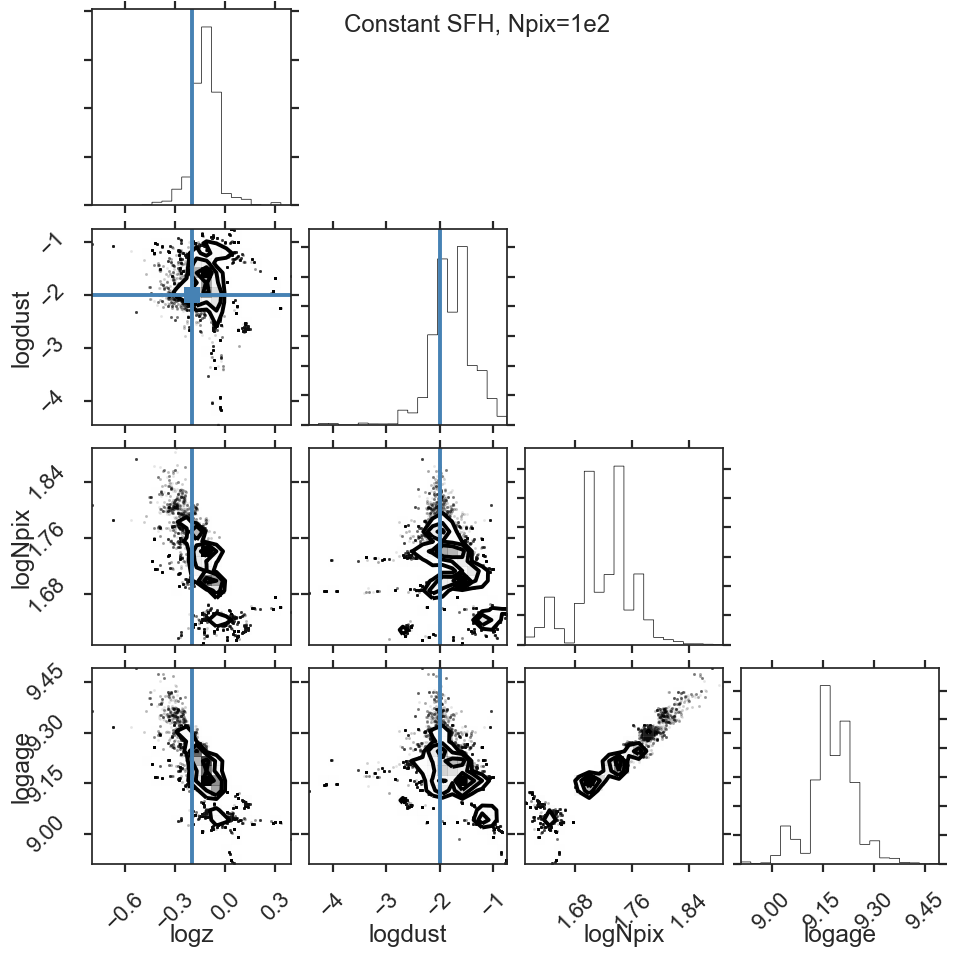

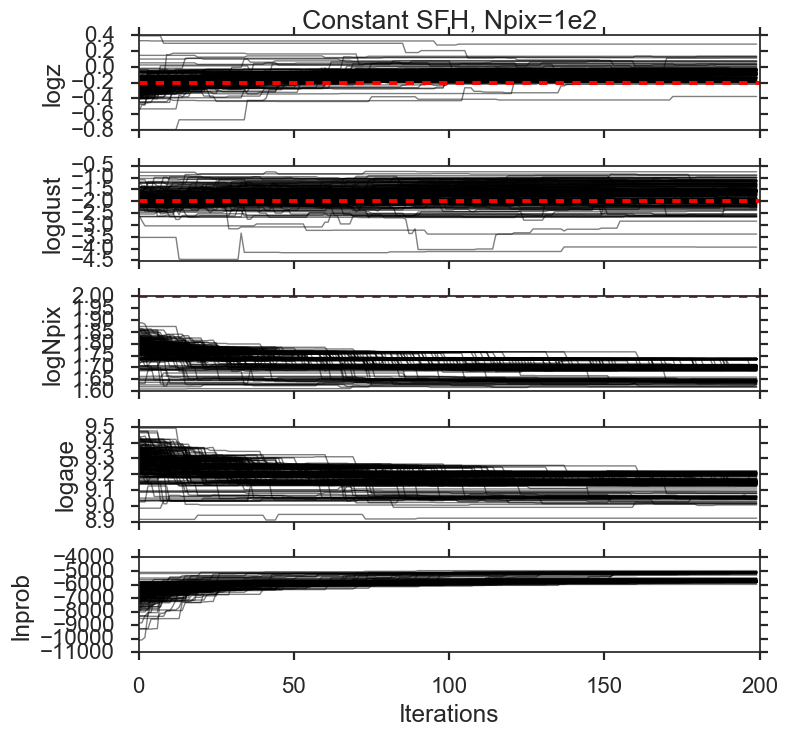

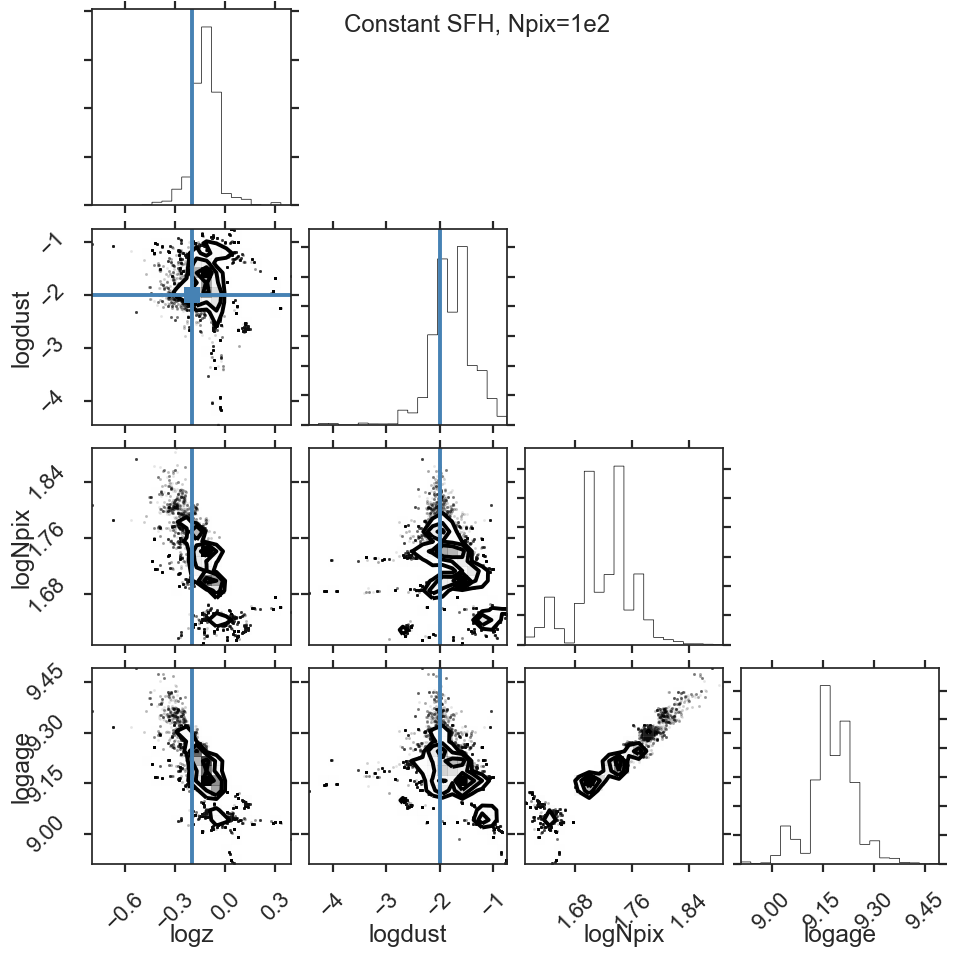

In [38]:
run_FULL_as_SSP = PCMD_run('results/FULL_as_SSP_mock.csv', truths=FULL_as_SSP_truths(), simple=True, title='Constant SFH, Npix=1e2')
run_FULL_as_SSP.chain_plot()
run_FULL_as_SSP.corner_plot()
# run_FULL_as_SSP.cumSFH_plot()

In [63]:
Npix = 1e2
tau = 1e9
age_edges = 10.**np.array([6., 7., 8., 8.5, 9.0, 9.5, 10., 10.2])
exp_factors = np.exp((age_edges-10.**10.2) / tau)
logsfhs = np.log10(Npix * (exp_factors[1:] - exp_factors[:-1]))
params_start = np.append(np.array([-0.2, -2]), logsfhs)

In [64]:
logsfhs

array([-6.92647108, -5.90482841, -5.45696379, -4.75394921, -3.56283146,
       -0.54062491,  1.99874613])

In [65]:
cumsfh = np.cumsum(10.**logsfhs)

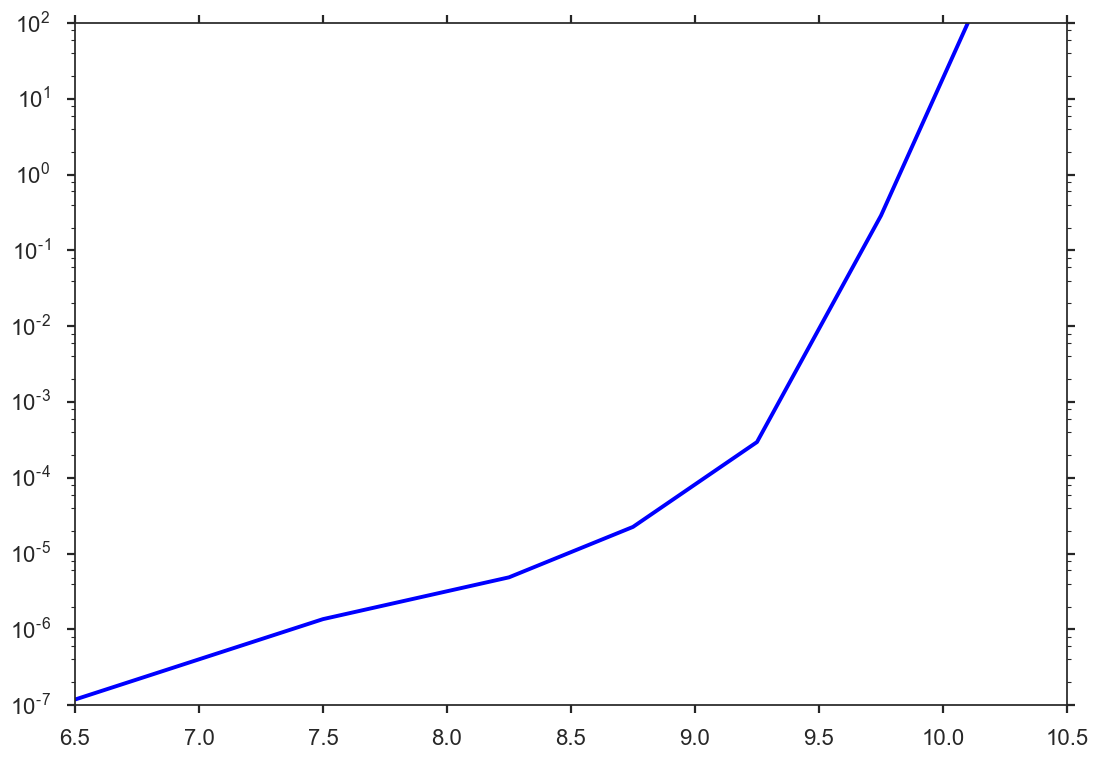

In [69]:
plt.plot(0.5*(np.log10(age_edges[1:])+np.log10(age_edges[:-1])),cumsfh)
plt.yscale('log')